# Project for the 'Programming for Data Analysys'
***

### Table of content
[1. Problem statement](#par1)<br>
[2. Simulate the data using``numpy.random`` package](#par2)<br>
[2.1 Simulate single variable](#par2.1)<br>
[2.1.1 Perfect process](#par2.1.1)<br>
[2.1.1 Simulate 'special causes'](#par2.1.2)<br>
[2.2 Simulate scrap ratio based on 10 dimensions](#par2.2)<br>
[3. Analise the data](#par3)<br>
<hr>

### Import all the packages

In [1]:
# import all the packackes used in the notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, colors
import seaborn as sns 
from scipy.stats import weibull_min, norm, ttest_ind

import warnings
# For predicting the scrap in lot using machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss
from sklearn.exceptions import ConvergenceWarning

import MySPC as spc

In [2]:
# Create the new instance of the numpy psudorandom numbers Generator
rng = np.random.default_rng()

<a id="par1"></a>
## 1. Problem statement


Variability in any manufacturing process can be divided into two distinct categories [1]: 
- Random or natural variability, which is naturally present in any process or system. This can be caused by machine vibration, natural changes in raw material hardness, errors in machine axis encoders etc. Process that has only natural variability is called statistically stable process
- Assignable or special cause variability. This variability is not inherent part of the process, and the sources of this variability can be identified and removed from the process.

In the Section 3.1.1. I will stimulate the result of a process that has only common causes of variability present. This type of process can be described with a normal distribution 
Distribution of a measurements of a single dimension in the stable manufacturing process (process that has no special causes) follows normal distribution.

In Section 3.1.2 I will be adding special (or assignable) sources of process variability. First I will add batch to batch variation caused by changes in the fixture setup, next variability caused by the cutting tool: differences in the tool size, tool wear and tool failure.

The following assumptions were made:
- Single manufacturing process step is modelled
- Each part has 10 dimensions that are independently measured
    - Some dimensions are correlated
- If any of the 10 dimensions is measured outside of the specified limit, part is scrapped
- Parts are manufactured in batches of 10

<a id="par2"></a>
## 2. Simulate the data using ```numpy.random``` package

<a id="par2.1"></a>
### 2.1 Simulate single variable

<a id="par2.1.1"></a>
#### 2.1.1 Process with with Inherent process variation only

Inherent Process Variation: the portion of the process variation that is due to common causes only [1].

##### Define Dim1 attributes

Process capability: the 6$\sigma$ range of the process's inherent variation (variation without the special causes).

$$
C_{p}=\frac{USL-LSL}{6\sigma}
$$

Given the process capability and upper and lower service limits, we can calculate the underlying process standard deviation:


$$
\sigma=\frac{USL-LSL}{6 C_{p}}
$$

##### Define the process and the inherent variation parameters

In [3]:
# Nominal dimension
mean = 9.5
# Upper and Lower tollerances
lsl, usl = 9.4, 9.6
# Process capability
cp = 2.
# Number of lots
nr_lots = 20
# Parts in the lot 
nr_in_lot = 10
# Total number of parts
n = nr_lots*nr_in_lot

##### Simulate the inherent process variation using normal distribution

In [4]:
# Simulate the measurements of single dimenension using normal distribution
# ccv stands for common cause variation
dim1 = pd.DataFrame({'ccv': rng.normal(mean, (usl-lsl)/(6*cp) , n)})

##### Show distribution of dim1 using Histogram

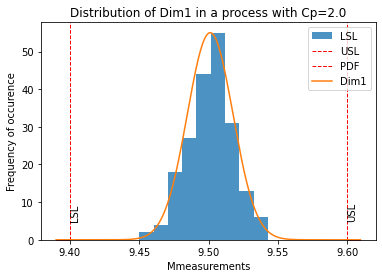

In [5]:
fig, ax = spc.hist(dim1, 'Dim1', lsl, usl, cp)

##### Check Dim1 with Statistical Process Control charts

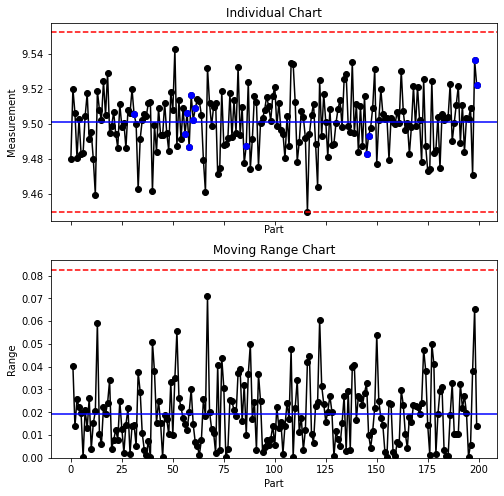

In [6]:
o = spc.xmr(dim1.loc[:,'ccv'])

##### Process not centered at nominal

More realistic scenarion would be a situation where the manufacturing process is not perfectly centered on the nominal value. This can be caused by:
- Lack of machine calibration
- Poor process design

In [7]:
# Simulate the effect of proces not being centered at the nominal
# The mean of such process would be pooled from normal distribution:

proc_mean=rng.normal(mean, (usl-lsl)/6)

dim1['ccv_off_center'] = dim1['ccv'] + mean - proc_mean

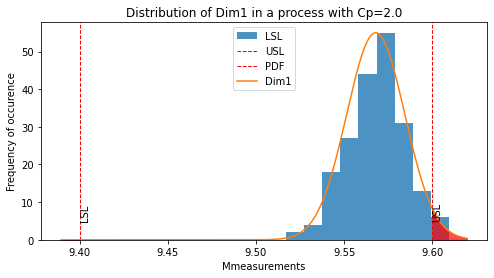

In [8]:
# As seen on the histogram plot, process without special causes variability is alredy not centered perfectly between upper and lower service limits
fig, ax = spc.hist(dim1['ccv_off_center'], 'Dim1', lsl, usl, cp)

<a id="par2.1.2"></a>
#### 2.1.2 Simulate 'special causes'

##### Variation between the batches

Vatiation between the batches can be casued by:
- difrences in the fixture setup
- changes in the raw material (material hardness, forging size etc)

Distribution of batch-to-batch variation is normal.

In [9]:
# define the ratio of batch-to-batch standard deviation to the dimension tolerance
# The larger the number, the smallest the effect of this special cause 
btb_sd_ratio = 20

# create a array with adjustment for each lot
lots = rng.normal(0, (usl-lsl)/btb_sd_ratio , nr_lots)

# add the same adjustment for each 'nr_in_lot' in a lot
part = 0
for l in lots:
    for p in range(nr_in_lot):
        dim1.loc[part, 'btb'] = l
        part = part + 1


# Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
dim1['measured'] = dim1['ccv_off_center'] + dim1['btb']

# Show data for parts in 2 first lots to make sure btb is calculated correctly       
dim1.head(2*nr_in_lot)

ccv  ccv_off_center       btb  measured
0   9.479882        9.546620 -0.009415  9.537205
1   9.520194        9.586932 -0.009415  9.577517
2   9.506424        9.573162 -0.009415  9.563747
3   9.480743        9.547481 -0.009415  9.538066
4   9.502956        9.569694 -0.009415  9.560279
5   9.483186        9.549924 -0.009415  9.540509
6   9.483446        9.550184 -0.009415  9.540769
7   9.504520        9.571258 -0.009415  9.561843
8   9.517581        9.584319 -0.009415  9.574904
9   9.491345        9.558083 -0.009415  9.548668
10  9.495258        9.561996  0.009337  9.571333
11  9.480144        9.546882  0.009337  9.556220
12  9.459709        9.526447  0.009337  9.535784
13  9.518978        9.585716  0.009337  9.595053
14  9.508317        9.575055  0.009337  9.584393
15  9.502232        9.568969  0.009337  9.578307
16  9.524542        9.591280  0.009337  9.600618
17  9.505205        9.571943  0.009337  9.581280
18  9.529132        9.595869  0.009337  9.605207
19  9.495070        9.561808  0.009337  9.571145

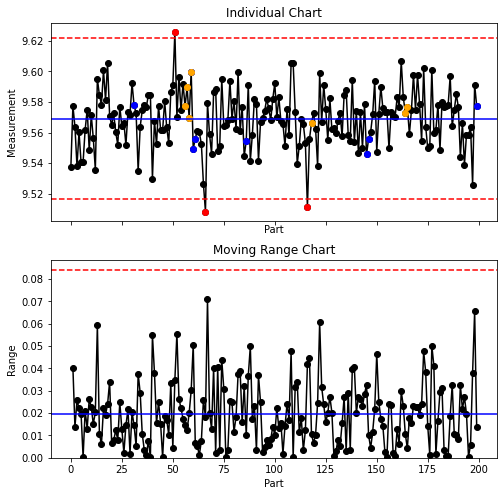

In [10]:
# Check the SPC chart for the measured dimension (common cause variation with batch-to-batch variation)
o = spc.xmr(dim1.loc[:,'measured'])

##### Effect of the tool size variation

In [11]:
# define tool life: how many lots can be processed by one tool
lots_per_tool = 4
# tool tolerance
# Example tool tolerances: http://www.mitsubishicarbide.com/en/technical_information/tec_rotating_tools/face_mills/tec_milling_guide/tec_milling_tolerance
tool_tol = 0.02

In [12]:
# Distribution of changes in tool sizes will be pooled from uniform distribution from interval -tool_tol to 0
nr_of_tools = int(np.ceil(nr_lots/lots_per_tool))
tools = rng.uniform(-tool_tol, 0 , nr_of_tools)

# add the same adjustment to each part processed by one tool: lots_per_tool * nr_in_lot - lots_per_tool is in number of lots
part = 0
for t in tools:
    for p in range(nr_in_lot * lots_per_tool):
        dim1.loc[part, 'tcv'] = t
        part = part + 1
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

# Sum all the variations:
dim1['measured'] = dim1['ccv_off_center'] + dim1['btb'] + dim1['tcv']

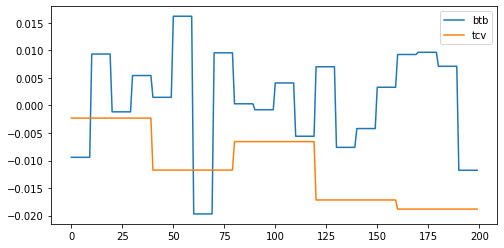

In [13]:
# Compare the impact from batch-to-batch variation with tool-change variation
dim1[['btb','tcv']].plot()
plt.show()

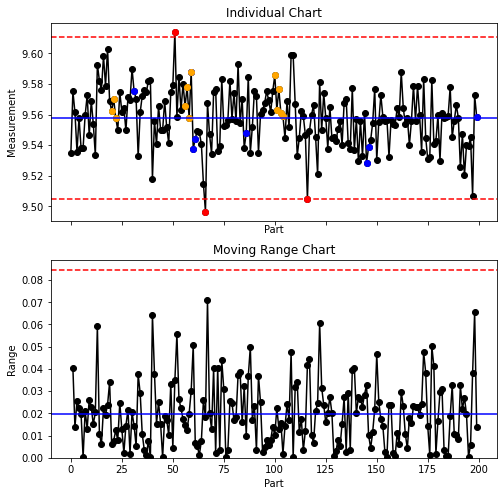

In [14]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = spc.xmr(dim1.loc[:,'measured'])

##### Effect of a tool wear

In [15]:
# Tool wear can be aproximated with a linear model, as per:
# https://www.sciencedirect.com/science/article/pii/S235197891630049X/pdf?md5=de5447dd9c5745bc8a5638dc26d7d66c&pid=1-s2.0-S235197891630049X-main.pdf
# https://journals.sagepub.com/doi/pdf/10.1177/1687814017750434

# Define the maximum tool wear
max_tool_wear = 0.04

In [16]:
# Calculate the tool wear assuming linear tool-wear model
inc_wear = max_tool_wear/(nr_in_lot * lots_per_tool)

part = 0

for t in tools:
    # No tool wear for the firts part
    dim1.loc[part, 't_wear'] = 0
    for p in range(1, nr_in_lot * lots_per_tool):
        part = part + 1
        # pool a random number between 0 and inc_wear and add it to the previous part wear to calculate the total tool wear for current part
        dim1.loc[part, 't_wear'] =  dim1.loc[part-1, 't_wear'] + rng.uniform(0, inc_wear)
        # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
        # exiting the loop when part count reaches nr_lots*nr_in_lot
        if part==nr_lots*nr_in_lot:
            break

dim1['measured'] = dim1['ccv_off_center'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear']           

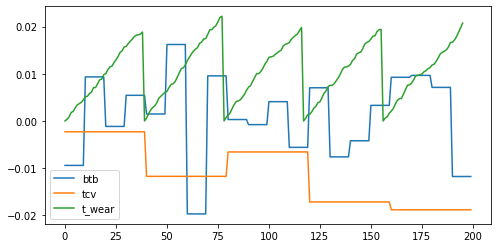

In [17]:
# Compare the impact from batch-to-batch variation, tool-change variation and tool wear
dim1[['btb','tcv', 't_wear']].plot()
plt.show()

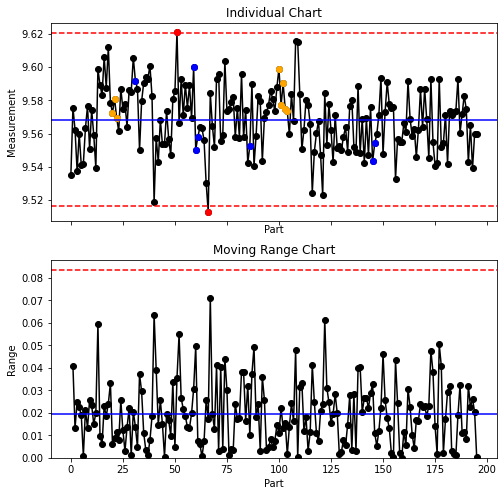

In [18]:
# Check the SPC chart for the measured dimension (common cause variation plus batch-to-batch variation and tool-change variation)
o = spc.xmr(dim1.loc[:,'measured'])

##### Model tool failure

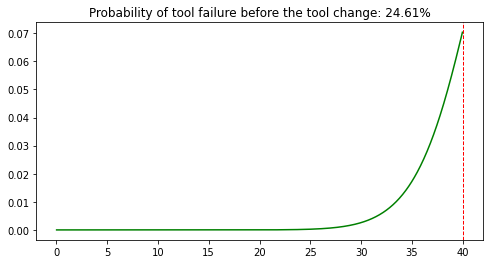

In [19]:
# Model number of parts machined by each tool using Weibull distribution
# https://www.researchgate.net/publication/226636244_Prediction_of_tool_failure_rate_in_turning_hardened_steels

# Shape parameter
a = 12
# scale parameter
lam = nr_in_lot * lots_per_tool  
# location parameter
mu = nr_in_lot * lots_per_tool * 0.1

# Round down to the nearest integer
tool_life = np.floor(weibull_min.rvs(a, loc=mu, scale=lam, size=nr_of_tools))

# define the x axis of the plot
x = np.arange(1, 1000.)/1000.*lam

y = weibull_min.pdf(x, a, loc=mu, scale=lam)
plt.plot(x, y, color='green', label='Scaled cdf')
plt.title('Probability of tool failure before the tool change: {:.2%}'.format(weibull_min.cdf(40, a, loc=mu, scale=lam)))
plt.axvline(nr_in_lot * lots_per_tool, color='r', linestyle='dashed', linewidth=1)
plt.show()

In [20]:
tool_life

array([45., 46., 45., 47., 43.])

In [21]:
part = 0

dim1['t_break'] = 0

for tl in tool_life:
    # if tool life is greater than number of parts processed by tool:
    if tl>=nr_in_lot * lots_per_tool:
        part = part + nr_in_lot * lots_per_tool
        if part>=nr_lots*nr_in_lot:
            break        
    # if tool life is smaller than number of parts processed by tool:
    else:
        part = part + int(tl)
        if part>=nr_lots*nr_in_lot:
            break        
        for p in range(int(tl), nr_in_lot * lots_per_tool):
            # Assign random value from normal distribution centered around 0.1
            # Chipped cutting tool will have smaller size causing large shift in the machined size
            # but rougher edge will introduce more variation to the process
            dim1.loc[part, 't_break'] = rng.normal(0.1, 0.01)
            part = part + 1
            # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
            # exiting the loop when part count reaches nr_lots*nr_in_lot
            if part>=nr_lots*nr_in_lot:
                break
                
dim1['measured'] = dim1['ccv_off_center'] + dim1['btb'] + dim1['tcv'] + dim1['t_wear'] + dim1['t_break']

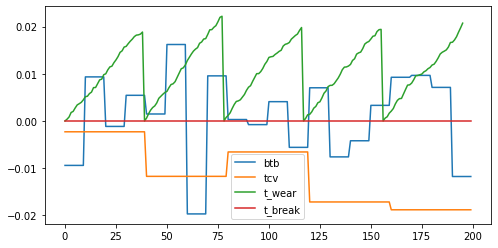

In [22]:
# Compare the impact from batch-to-batch variation, tool-change variation, tool wear and tool failure
dim1[['btb','tcv', 't_wear', 't_break']].plot()
plt.show()

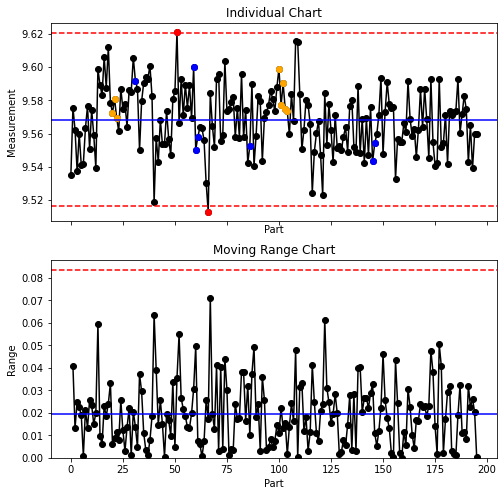

In [23]:
# Check the SPC chart for the measured dimension
o = spc.xmr(dim1.loc[:,'measured'])

### Calculate the Process Performance Index $P_{pk}$

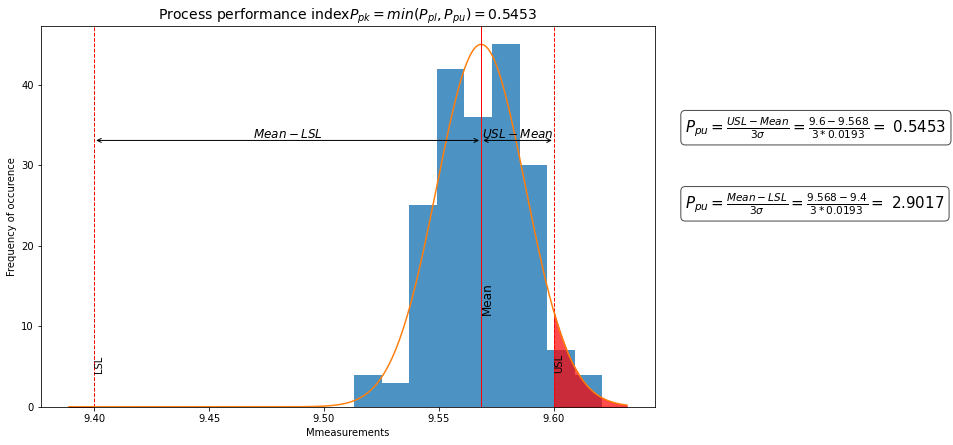

In [24]:
# Show distribution of the measurments with total process variation (Inherent plus special causes)

fig, ax = spc.hist(dim1['measured'], 'Dim1', lsl, usl, cp)

fig.set_size_inches(11, 7)

# Calculate the mean of the measured values
mean = dim1['measured'].mean()

#calculate the standard deviation of the measurements
sigma = dim1['measured'].std()

#calculate the Ppl and Ppu
ppl = (mean-lsl)/(3*sigma)
ppu = (usl-mean)/(3*sigma)

# Get the max y value of this plot
y_max = ax.get_ylim()[1]

ax.axvline(mean, color='r', linestyle='-', linewidth=1)
ax.text(mean, y_max/4, 'Mean',rotation=90, fontsize=12)

# Mathematical expressions in Matplotlib:
#https://matplotlib.org/stable/tutorials/text/mathtext.html
ax.set_title('Process performance index' + r'$P_{pk} = min(P_{pl}, P_{pu})= $' + '{:.4}'.format(min(ppl, ppu)), fontsize=14)


ppl_line = ax.annotate("",
            xy=(lsl, y_max*0.7), xycoords='data',
            xytext=(mean, y_max*0.7), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )

ppl_txt = ax.annotate(r'$Mean-LSL$', 
                      xy=((lsl + mean)/2, y_max*0.7), xycoords=("data"), 
                      horizontalalignment='center', verticalalignment='bottom',
                      fontsize=12
                     )


ppu_line = ax.annotate("",
            xy=(usl, y_max*0.7), xycoords='data',
            xytext=(mean, y_max*0.7), textcoords='data',
            arrowprops=dict(arrowstyle="<->",
                            connectionstyle="arc3"),
            )

ppl_txt = ax.annotate(r'$USL-Mean$', 
                      xy=((usl + mean)/2, y_max*0.7), xycoords=("data"), 
                      horizontalalignment='center', verticalalignment='bottom',
                      fontsize=12,
                     )

# https://stackoverflow.com/questions/33786332/matplotlib-using-variables-in-latex-expressions
desc = ax.annotate(r'$P_{pu} = \frac {USL-Mean}{3\sigma}$' + r'$ = \frac{{{:.4}-{:.4}}}{{3*{:.4f}}} =$ {:.4f}'.format(usl, mean, sigma, ppu),
                      xy=(1.05, 0.7), xycoords=("axes fraction"), 
                      horizontalalignment='left', verticalalignment='bottom',
                      fontsize=15,
                      bbox=dict(boxstyle="round", fc="w", alpha=0.7) 
                     )

desc = ax.annotate(r'$P_{pu} = \frac {Mean-LSL}{3\sigma}$' + r'$ = \frac{{{:.4}-{:.4}}}{{3*{:.4f}}} =$ {:.4f}'.format(mean,lsl, sigma, ppl),
                      xy=(1.05, 0.5), xycoords=("axes fraction"), 
                      horizontalalignment='left', verticalalignment='bottom',
                      fontsize=15,
                      bbox=dict(boxstyle="round", fc="w", alpha=0.7) 
                     )

# Remove the legend, as the plot would get too busy
legend = ax.legend()
legend.remove()

plt.show()

$P_{pk}$ - the performance index which account for the process centering. It's determined by calculating partial indices $P_{pl}$ and $P_{pu}$ (as a fraction of a difference between the process mean and the Upper and Lower Service Limits and the 3 times the sample standard deviation) and then taking the lower value as $P_{pk}$.

In [25]:
dim1

ccv  ccv_off_center       btb  measured       tcv    t_wear  t_break
0    9.479882        9.546620 -0.009415  9.534911 -0.002294  0.000000        0
1    9.520194        9.586932 -0.009415  9.575595 -0.002294  0.000372        0
2    9.506424        9.573162 -0.009415  9.562295 -0.002294  0.000842        0
3    9.480743        9.547481 -0.009415  9.537565 -0.002294  0.001792        0
4    9.502956        9.569694 -0.009415  9.560010 -0.002294  0.002025        0
..        ...             ...       ...       ...       ...       ...      ...
195  9.503149        9.569887 -0.011767  9.560020 -0.018817  0.020718        0
196  9.508988        9.575726 -0.011767       NaN -0.018817       NaN        0
197  9.470862        9.537600 -0.011767       NaN -0.018817       NaN        0
198  9.536391        9.603129 -0.011767       NaN -0.018817       NaN        0
199  9.522411        9.589149 -0.011767       NaN -0.018817       NaN        0

[200 rows x 7 columns]

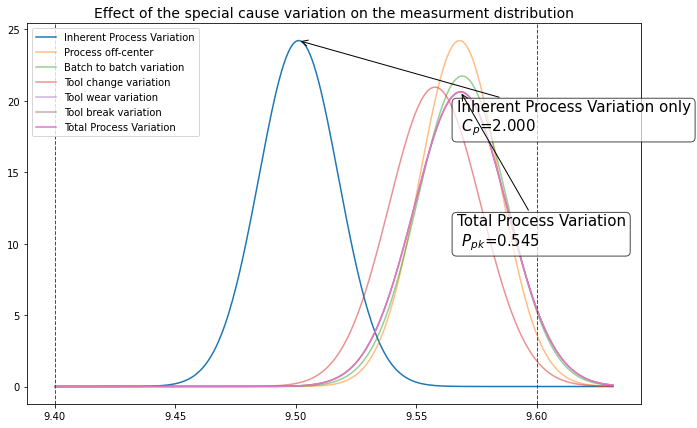

In [26]:
# Plot comparison for the Inherent Process Variation only and Total Process Variation

fig, ax = plt.subplots(figsize=(11,7))


ax.set_title('Effect of the special cause variation on the measurment distribution', fontsize=14)

# Calculate the mean of the measured values
mean = dim1['measured'].mean()
mean_ccv = dim1['ccv'].mean()

#calculate the standard deviation of the measurements
sigma = dim1['measured'].std()
sigma_ccv = dim1['ccv'].std()

#Calculate the X axis limits to ensure that it includes the whole tollerance band and 99.9% of both distributions

# choose the x_min from lsl and the bottom intervals that contains 99.9% of both distributions
x_min = min(lsl, norm.interval(0.999, loc=mean, scale=sigma)[0], norm.interval(0.999, loc=mean_ccv, scale=sigma_ccv)[0])
# choose the x_max from usl and the top intervals that contains 99.9% of both distributions
x_max = max(usl, norm.interval(0.999, loc=mean, scale=sigma)[1], norm.interval(0.999, loc=mean_ccv, scale=sigma_ccv)[1])

#create a array of x values
x = np.arange(x_min, x_max, (x_max-x_min)/500. )


# Add distribution plot for the process with Inherent variation only
y_ccv = norm.pdf(x, loc=mean_ccv, scale=sigma_ccv)
ax.plot(x, y_ccv, label='Inherent Process Variation')

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['ccv_off_center'].mean(), scale=dim1['ccv_off_center'].std())
ax.plot(x, y, label='Process off-center', alpha=0.5)

dim1['measured'] =  dim1['ccv_off_center'] + dim1['btb']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Batch to batch variation', alpha=0.5)


dim1['measured'] =  dim1['measured'] + dim1['tcv']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Tool change variation', alpha=0.5)


dim1['measured'] =  dim1['measured'] + dim1['t_wear']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Tool wear variation', alpha=0.5)


dim1['measured'] =  dim1['measured'] + dim1['t_break']

# Add distribution plot for the process with Inherent variation  and being off-center
y = norm.pdf(x, loc=dim1['measured'].mean(), scale=dim1['measured'].std())
ax.plot(x, y, label='Tool break variation', alpha=0.5)


# Add the distribution plot for the final process, with inherent and all the special causes variation 
y = norm.pdf(x, loc=mean, scale=sigma)
ax.plot(x, y, label='Total Process Variation', alpha=1)



# Draw red vertical lines for upper and lower tolerances
ax.axvline(usl, color='r', linestyle='dashed', linewidth=1)
ax.axvline(lsl, color='r', linestyle='dashed', linewidth=1)

# Add the annotation for the Cp
desc = ax.annotate('Inherent Process Variation only\n '+r'$C_{p}$='+'{:.3f}'.format(cp),
                   xy=(mean_ccv, max(y_ccv)), xycoords= 'data',
                   xytext=(0.7, 0.7), textcoords= 'axes fraction',
                   arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),
                   horizontalalignment='left', verticalalignment='bottom',
                   fontsize=15,
                   bbox=dict(boxstyle="round", fc="w", alpha=0.7)
                     )

# Add the annotation for the Ppk
desc = ax.annotate('Total Process Variation\n '+r'$P_{pk}$='+'{:.3f}'.format(min(ppl, ppu)),
                   xy=(mean, max(y)), xycoords= 'data',
                   xytext=(0.7, 0.4), textcoords= 'axes fraction',
                   arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),
                   horizontalalignment='left', verticalalignment='bottom',
                   fontsize=15,
                   bbox=dict(boxstyle="round", fc="w", alpha=0.7)
                     )

# Add the legend
ax.legend(loc='upper left')

plt.show()

<a id="par2.2"></a>
### 2.2 Simulate 10 independent variables

##### Define process step parameters

In [27]:
# Number of days
n_days = 30
# Numbers of batches (lots) manufactured in one day
nr_lots = 20
# Parts in a lot 
parts_in_lot = 10
# Total number of parts
n_parts = n_days* nr_lots * parts_in_lot

#### 2.2.1 Create a table of process definitions

In [28]:
# Create a table of 10 process definitions:
# Number of independent variables to be simulated:
n_dim = 20

# list of typical tolerances used in manufacturing process and their typical frequency of use
tol_array = [0.02, 0.05, 0.10, 0.20]
tol_freq =  [0.10, 0.20, 0.50, 0.20]

dim_def = pd.DataFrame({'Nominal': np.round(rng.uniform(3, 10, n_dim), 1) })
dim_def['tolerance'] = rng.choice(tol_array, n_dim, p=tol_freq )
dim_def['LSL'] = dim_def['Nominal']-dim_def['tolerance']
dim_def['USL'] = dim_def['Nominal']+dim_def['tolerance']

dim_def['Cp'] = rng.normal(2, 0.5, n_dim)

# number of parts made by single tool will be pooled from natural numbers between 1 and 9:
dim_def['lots_per_tool'] = rng.choice(range(1,10), n_dim)

# tool tolerance will be randomly selected from the following list:
dim_def['tool_tol '] = rng.choice([0.01, 0.02, 0.04], n_dim)

# max tool wear per process randomly selected from the following values:
dim_def['max_tool_wear'] = rng.choice([0.01, 0.02, 0.04], n_dim)

# Tool failure probability from Webul distribution
a = 12
dim_def['tool_weibul_a'] = a
dim_def['tool_weibul_loc'] = parts_in_lot * dim_def['lots_per_tool'] * rng.uniform(0.1, 0.3, n_dim)
dim_def['tool_weibul_scale'] = parts_in_lot * dim_def['lots_per_tool']
dim_def['tool_failure_prob'] = weibull_min.cdf(parts_in_lot * dim_def['lots_per_tool'], a, loc=dim_def['tool_weibul_loc'], scale=dim_def['tool_weibul_scale'])

dim_def

Nominal  tolerance   LSL    USL        Cp  lots_per_tool  tool_tol   \
0       7.8       0.10  7.70   7.90  1.233884              9       0.02   
1      10.0       0.20  9.80  10.20  2.039927              3       0.01   
2       8.4       0.05  8.35   8.45  2.152818              2       0.01   
3       8.2       0.05  8.15   8.25  2.016659              6       0.01   
4       6.4       0.10  6.30   6.50  1.955352              7       0.02   
5       9.3       0.10  9.20   9.40  2.475769              8       0.02   
6       6.8       0.10  6.70   6.90  1.693396              9       0.01   
7       9.5       0.10  9.40   9.60  1.947971              5       0.01   
8       3.5       0.20  3.30   3.70  2.975514              8       0.02   
9       4.1       0.05  4.05   4.15  2.276054              4       0.02   
10      4.0       0.02  3.98   4.02  2.103596              1       0.01   
11      4.6       0.10  4.50   4.70  1.562447              1       0.04   
12      5.7       0.20  5.50   5.90  1.726668              1       0.02   
13      9.1       0.10  9.00   9.20  2.268664              8       0.04   
14      7.9       0.10  7.80   8.00  1.444226              5       0.04   
15      3.5       0.10  3.40   3.60  2.011971              6       0.04   
16      4.6       0.05  4.55   4.65  1.760462              3       0.02   
17      3.3       0.10  3.20   3.40  1.516216              3       0.01   
18      5.7       0.05  5.65   5.75  1.973224              6       0.04   
19      4.6       0.10  4.50   4.70  3.274091              9       0.02   

    max_tool_wear  tool_weibul_a  tool_weibul_loc  tool_weibul_scale  \
0            0.01             12        11.874606                 90   
1            0.04             12         3.249031                 30   
2            0.04             12         4.868730                 20   
3            0.02             12        15.326612                 60   
4            0.02             12        14.463066                 70   
5            0.01             12        13.599834                 80   
6            0.01             12        20.649731                 90   
7            0.04             12         5.372092                 50   
8            0.02             12        10.228325                 80   
9            0.04             12         6.869312                 40   
10           0.02             12         1.751369                 10   
11           0.04             12         2.701216                 10   
12           0.01             12         2.602132                 10   
13           0.04             12         9.302439                 80   
14           0.01             12        13.329549                 50   
15           0.02             12        11.227951                 60   
16           0.02             12         6.497714                 30   
17           0.01             12         5.966853                 30   
18           0.02             12         9.552902                 60   
19           0.01             12        21.225400                 90   

    tool_failure_prob  
0            0.167283  
1            0.223305  
2            0.034557  
3            0.028608  
4            0.060307  
5            0.101378  
6            0.042873  
7            0.225584  
8            0.176073  
9            0.098993  
10           0.094453  
11           0.022597  
12           0.026513  
13           0.202974  
14           0.023928  
15           0.079853  
16           0.052037  
17           0.067482  
18           0.117328  
19           0.038873

####  2.2.2 Create a table with dimension measurements for all the features

##### Prepare DataFrame to hold all the measurements

In [29]:
# Create an all_dims Dataframe with a first columns: 'Date' and 'Lot'

days = []
lots = []

for day in range(n_days):
    for lot in range(nr_lots):        
        for part in range(parts_in_lot):
            # There will be 'parts_in_lot * nr_lots' parts made in every day, all these rows will have the same value in the 'Date' column
            days.append(day)
            # Make sure that lot number is unique for every batch
            lots.append(day*nr_lots + lot)
        
all_dims = pd.DataFrame({'Date': days, 'Lot': lots})

In [30]:
# Create a DataFrame to keep all the parameters for each lot and dimension
lot_parameters = pd.DataFrame({'Lot': all_dims['Lot'].unique()})
lot_parameters.set_index('Lot', inplace=True)

##### Run the simulation

In [31]:
# Simulate the n_dim number of features processed over n_days days:

all_parts = nr_lots*parts_in_lot*n_days

dim = pd.DataFrame(all_dims['Lot'])

# Iterate through the columns of all_dims DataFrame:
for dim_row, index in dim_def.iterrows():
    column = "Dim" + str(dim_row + 1)
    mean = index[0]
    tol = index[1] * 2
    cp = index[4]
    # Tool parameters:
    lots_per_tool = int(index[5])
    tool_tol = index[6]
    max_tool_wear = index[7]
    # Tool failure Weibull distribution parameters
    # Shape parameter
    a = index[8]
    # scale parameter
    mu = index[9]
    # location parameter
    lam = index[10]
    
    # Simulate the effect of proces not being centered at the nominal
    # The mean of such process would be pooled from normal distribution:
    proc_mean=rng.normal(mean, tol/6)
    
    dim['ccv'] = rng.normal(proc_mean, tol/(6*cp) , n_parts)
    #dim = pd.DataFrame({'ccv': rng.normal(proc_mean, tol/(6*cp) , n_parts)})
    
    # ADD BATCH TO BATCH VARIATION
    
    # define the ratio of batch-to-batch standard deviation to the dimension tolerance
    # The larger the number, the smallest the effect of this special cause 
    btb_sd_ratio = rng.normal(20, 5)

    # create an array with adjustment for mean for each lot
    lots = rng.normal(0, tol/btb_sd_ratio , nr_lots * n_days)
    
    #add the values of the batch to batch variation to lot_parameters DataFrame    
    col='btb'+str(dim_row + 1)
    lot_parameters[col] = lots
    

    # add the same adjustment for each 'parts_in_lot' in a lot
    part = 0
    for l in lots:
        for p in range(parts_in_lot):
            dim.loc[part, 'btb'] = l
            part = part + 1            

            
    #ADD TOOL CHANGE VARIATION and EFFECT OF A TOOL WEAR
    
    # Calculate the tool wear assuming linear tool-wear model
    inc_wear = max_tool_wear/(nr_in_lot * lots_per_tool)
    
    # Distribution of changes in tool sizes will be pooled from uniform distribution from interval -tool_tol to 0
    nr_of_tools = int(np.ceil(nr_lots * n_days/lots_per_tool))
    tools = rng.uniform(-tool_tol, 0 , nr_of_tools)

    # add tool variation parameter to lot_parameter DataFrame
    tw = pd.DataFrame({'tcv': tools})
    # as per https://stackoverflow.com/questions/49074021/repeat-rows-in-data-frame-n-times
    tw = tw.loc[tw.index.repeat(lots_per_tool)].reset_index(drop=True)
    
    col='tcv'+str(dim_row + 1)
    lot_parameters[col] = tw.iloc[:,0]
    
    part = 0
    for t in tools:
        # No tool wear for the firts part processed by given tool
        dim.loc[part, 't_wear'] = 0
        for p in range(parts_in_lot * lots_per_tool):
            dim.loc[part, 'tcv'] = t           
            part = part + 1
            # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
            # exiting the loop when part count reachesall_parts = nr_lots*parts_in_lot*n_days
            if part==all_parts:
                break
            dim.loc[part, 't_wear'] =  dim.loc[part-1, 't_wear'] + rng.uniform(0, inc_wear) 
    
    
    
    # ADD EFFECT OF EARLY TOOL FAILURE


    # tool_life: number of processed part before tool failure, rounded down to the nearest integer:
    tool_life = np.floor(weibull_min.rvs(a, loc=mu, scale=lam, size=nr_of_tools))
    # initialize 't_break' column with all 0s
    dim['t_break'] = 0  
    
    # reset the part count
    part = 0
    for tl in tool_life:
        # if tool life is greater than number of parts processed by tool:
        if tl>=parts_in_lot * lots_per_tool:
            # increase the part count by number of parts processed by the tool
            part = part + parts_in_lot * lots_per_tool
            if part>=nr_lots*nr_in_lot:
                break        
        # if tool life is smaller than number of parts processed by tool:
        else:
            part = part + int(tl)
            if part>=nr_lots*nr_in_lot:
                break
            # Step through all the parts from in the range from tool Life to maximum processed by the tool    
            for p in range(int(tl), nr_in_lot * lots_per_tool):
                # Assign random value from normal distribution centered around 0.1
                # Chipped cutting tool will have smaller size causing large shift in the machined size
                # but rougher edge will introduce more variation to the process
                dim.loc[part, 't_break'] = rng.normal(0.1, 0.01)
                part = part + 1
                # when the ratio nr_lots/lots_per_tool is not an integer, additional rows would be created by this loop
                # exiting the loop when part count reaches nr_lots*nr_in_lot
                if part>=nr_lots*nr_in_lot:
                    break
    
    #add True to t_break column if Lot has parts machined with broken tool    
    col='t_break'+str(dim_row + 1)
    lot_parameters[col] = dim.groupby('Lot')['t_break'].sum()>0
    
    # ADD EFFECT OF COMMON CAUSES VARIATION AND ALL SPECIAL CAUSES 

    # Create a 'measured' column by adding a batch-to-batch variation to the base ccv dimensions
    all_dims[column] = dim['ccv'] + dim['btb'] + dim['tcv'] + dim['t_wear'] + dim['t_break']  

In [32]:
# Show simulated measurements
all_dims

Date  Lot      Dim1       Dim2      Dim3      Dim4      Dim5      Dim6  \
0        0    0  7.813844  10.119724  8.417219  8.170069  6.365802  9.324831   
1        0    0  7.824603  10.150212  8.413478  8.166135  6.372993  9.322597   
2        0    0  7.804888  10.087871  8.411988  8.181354  6.380050  9.303821   
3        0    0  7.857834  10.070039  8.419315  8.174309  6.390247  9.330085   
4        0    0  7.793770  10.147672  8.422935  8.173962  6.385147  9.295223   
...    ...  ...       ...        ...       ...       ...       ...       ...   
5995    29  599  7.860718  10.080200  8.414927  8.173118  6.385557  9.318507   
5996    29  599  7.796905  10.051053  8.410762  8.170174  6.377010  9.304274   
5997    29  599  7.817479  10.054525  8.421235  8.176137  6.378910  9.299780   
5998    29  599  7.800651  10.061482  8.417374  8.163709  6.341107  9.317849   
5999    29  599  7.859770  10.053858  8.424701  8.159612  6.358580  9.346970   

          Dim7      Dim8  ...     Dim11     Dim12     Dim13     Dim14  \
0     6.736339  9.509053  ...  4.004421  4.609345  5.719236  9.081001   
1     6.734166  9.520569  ...  4.007365  4.589132  5.673316  9.083170   
2     6.747674  9.487968  ...  4.002164  4.635588  5.709470  9.066264   
3     6.746818  9.514573  ...  4.008107  4.578254  5.705059  9.048125   
4     6.780695  9.521387  ...  4.009584  4.595112  5.696108  9.083125   
...        ...       ...  ...       ...       ...       ...       ...   
5995  6.770638  9.558680  ...  4.008719  4.601932  5.689530  9.018515   
5996  6.734092  9.519621  ...  4.016676  4.599865  5.646126  9.045498   
5997  6.761990  9.571929  ...  4.011378  4.599428  5.734981  9.025595   
5998  6.793686  9.530252  ...  4.010541  4.594055  5.659235  9.052995   
5999  6.770368  9.543714  ...  4.009768  4.598165  5.607498  9.055461   

         Dim15     Dim16     Dim17     Dim18     Dim19     Dim20  
0     7.905029  3.511803  4.540673  3.302875  5.693740  4.627760  
1     7.952101  3.548908  4.530581  3.337351  5.672856  4.637048  
2     7.882312  3.567369  4.535445  3.331721  5.695897  4.619640  
3     7.832125  3.541814  4.522930  3.281928  5.679109  4.636367  
4     7.911152  3.535931  4.537760  3.325281  5.680151  4.608718  
...        ...       ...       ...       ...       ...       ...  
5995  7.942217  3.541940  4.533969  3.316642  5.689190  4.652358  
5996  7.932398  3.513741  4.538850  3.311188  5.702980  4.634463  
5997  7.966518  3.513000  4.540181  3.323710  5.688381  4.617504  
5998  7.932234  3.553340  4.526712  3.305024  5.687936  4.627982  
5999  7.903104  3.530805  4.536927  3.349041  5.688527  4.632946  

[6000 rows x 22 columns]

<a id="par3"></a>
## 3. Analyse the data

##### Mark non-conformant (scrapped) parts in the all_dims table

In [33]:
# Check if any of the 10 dimensions in each part is outside of tolerance band
# Mark part as scrap if at least one dimension is outside of tolerance

all_dims['Scrap_all'] = False
for row, index in dim_def.iterrows():
    # Iterate through dim_def table and set the Upper and Lower Service Limits
    lsl = dim_def.iloc[row, 2]
    usl = dim_def.iloc[row, 3]
    # Compare the measurement (column by column from all_dims) against the Service Limits
    all_dims['Scrap' + str(row+1)] = (lsl > all_dims['Dim'+str(row+1)]) | (all_dims['Dim'+str(row+1)] > usl)
    all_dims['Scrap_all'] = all_dims['Scrap_all'] | all_dims['Scrap' + str(row+1)]

##### Plot number of scrapped parts per day

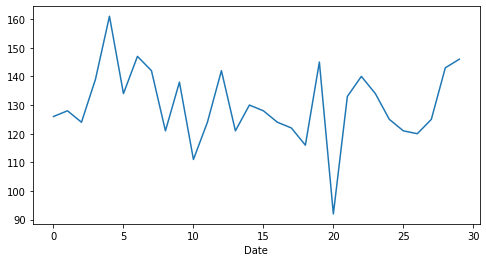

In [34]:
# Visualise amount of scraped part in every day
all_dims.groupby('Date').sum()['Scrap_all'].plot()
plt.show()

##### Join the number of scrapped parts to the 'lot_parameters' table

In [35]:
# Add scrapped parts per lot for each dimension to the lot_parameters dataframe
lot_parameters = lot_parameters.join(all_dims.groupby('Lot').sum().iloc[:,-(n_dim+1):])

In [36]:
# See the lot_parameters table
lot_parameters

btb1      tcv1  t_break1      btb2      tcv2  t_break2      btb3  \
Lot                                                                         
0    0.010805 -0.000397     False -0.010007 -0.009493     False -0.000326   
1   -0.002843 -0.000397     False  0.013022 -0.009493     False -0.005130   
2   -0.024073 -0.000397     False  0.017433 -0.009493     False -0.007611   
3    0.005842 -0.000397     False  0.031315 -0.009910     False  0.006692   
4    0.009761 -0.000397     False  0.013312 -0.009910     False -0.001799   
..        ...       ...       ...       ...       ...       ...       ...   
595 -0.011687 -0.012776     False -0.035721 -0.007942     False -0.000188   
596  0.014137 -0.012776     False  0.018167 -0.007942     False  0.000794   
597  0.012537 -0.012776     False  0.038539 -0.008601     False -0.001691   
598 -0.007502 -0.012776     False  0.004751 -0.008601     False  0.007548   
599  0.000068 -0.012776     False -0.050177 -0.008601     False -0.002905   

         tcv3  t_break3      btb4  ...  Scrap11  Scrap12  Scrap13  Scrap14  \
Lot                                ...                                       
0   -0.007283     False -0.003627  ...        0        0        0        0   
1   -0.007283     False  0.004341  ...        0        0        0        0   
2   -0.001836     False -0.005075  ...        0        0        0        0   
3   -0.001836     False  0.004380  ...        0        0        0        0   
4   -0.001262     False -0.003412  ...        0        0        0        0   
..        ...       ...       ...  ...      ...      ...      ...      ...   
595 -0.000746     False  0.001487  ...        0        0        0        0   
596 -0.008366     False -0.004477  ...        0        0        0        0   
597 -0.008366     False -0.006274  ...        1        0        0        0   
598 -0.008322     False  0.000585  ...        0        0        0        0   
599 -0.008322     False -0.003302  ...        0        0        0        0   

     Scrap15  Scrap16  Scrap17  Scrap18  Scrap19  Scrap20  
Lot                                                        
0          0        0       10        0        0        0  
1          0        0        8        0        0        0  
2          0        0        9        0        0        0  
3          0        0        9        1        0        0  
4          0        0        0        0        0        0  
..       ...      ...      ...      ...      ...      ...  
595        0        0        6        0        0        0  
596        0        0        7        0        0        0  
597        0        0        9        0        0        0  
598        0        0        9        0        0        0  
599        0        0       10        0        0        0  

[600 rows x 81 columns]

##### See the distribution of dimensions for all dimensions

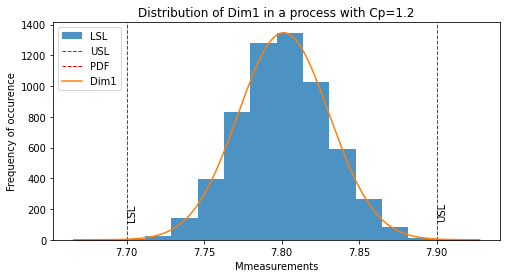

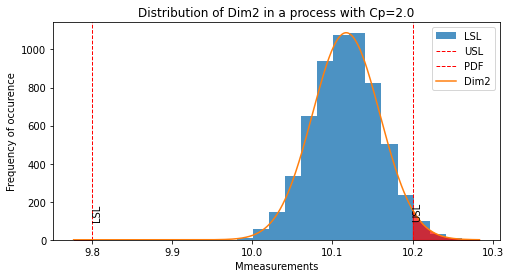

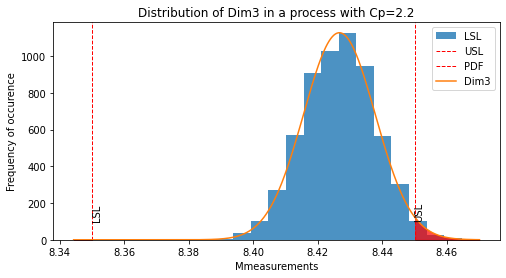

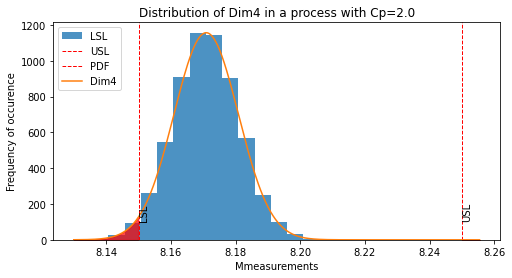

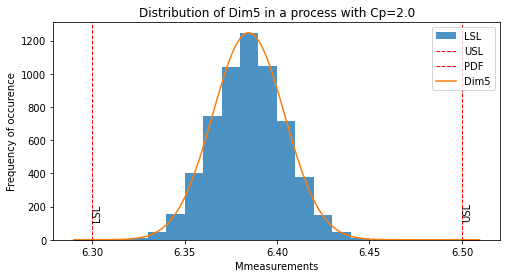

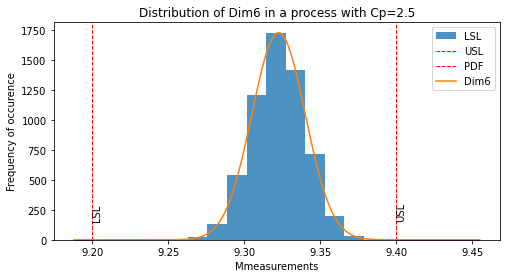

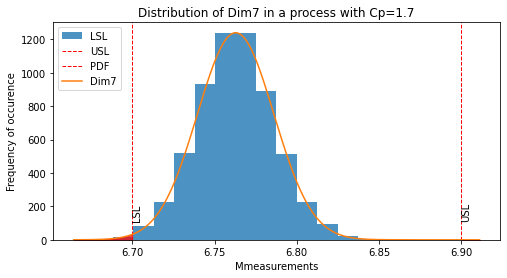

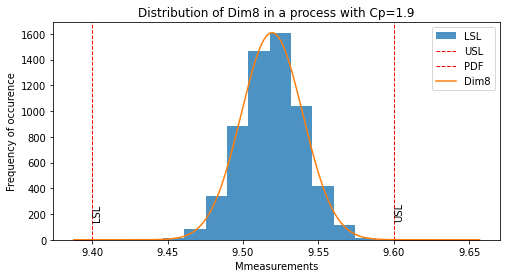

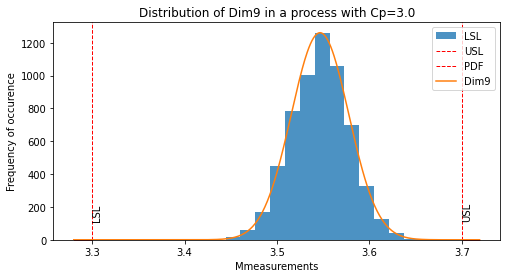

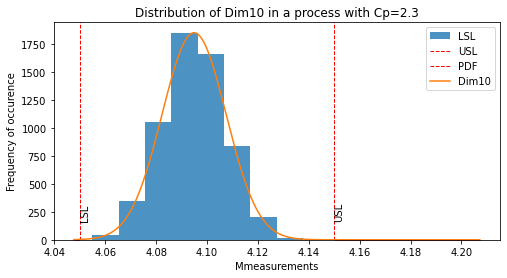

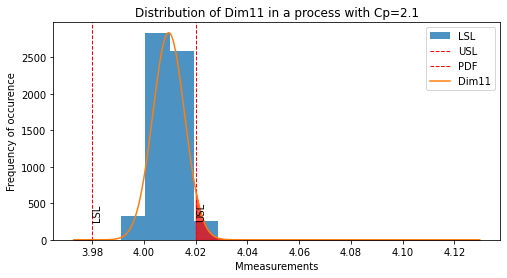

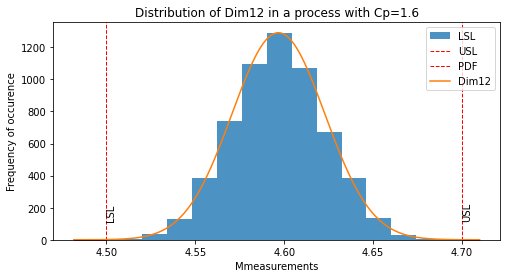

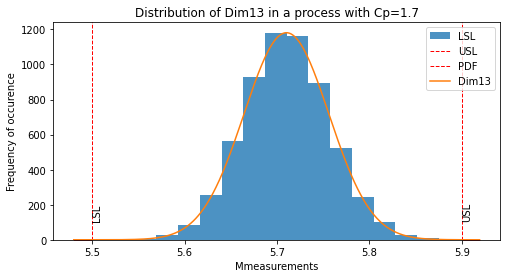

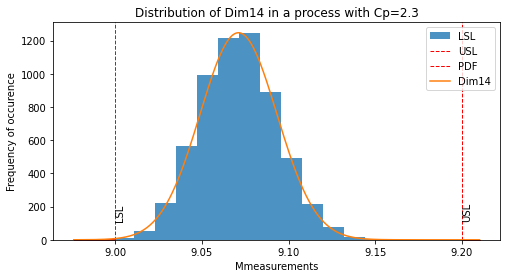

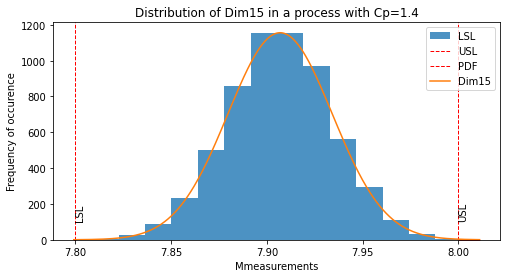

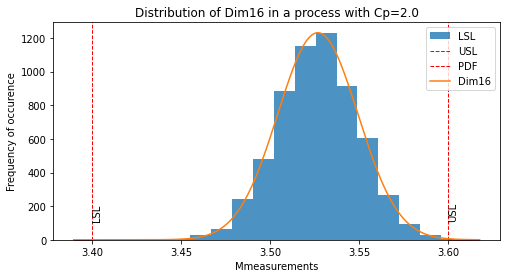

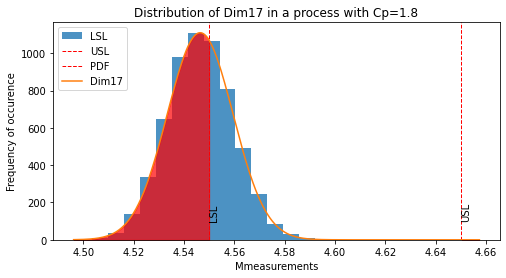

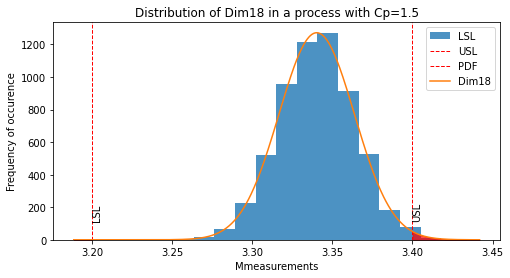

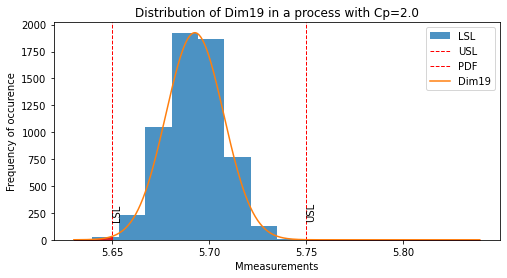

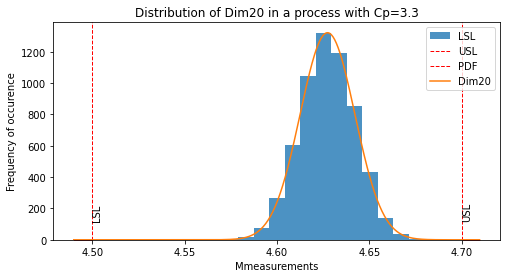

In [37]:
# Show all the dimensions distribution on histogram with LSL and USL marked
for row, index in dim_def.iterrows():
    column = "Dim" + str(row + 1)
    spc.hist(all_dims[column], column, dim_def.loc[row,'LSL'], dim_def.loc[row,'USL'], dim_def.loc[row,'Cp'])

##### Plot the X-bar S chart for each dimension for the last 120 lots and mark add standard deviationa and SPC rules violation for each lot to 'lot_parameters' table

C:\Users\Przemek\AppData\Local\Temp/ipykernel_25208/3181441916.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  lot_parameters["St_dev"+str(row + 1)] = xb['variability']
C:\Users\Przemek\AppData\Local\Temp/ipykernel_25208/3181441916.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  lot_parameters["SPC_Rule"+str(row + 1)] = xb['Reason']
C:\Users\Przemek\AppData\Local\Temp/ipykernel_25208/3181441916.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

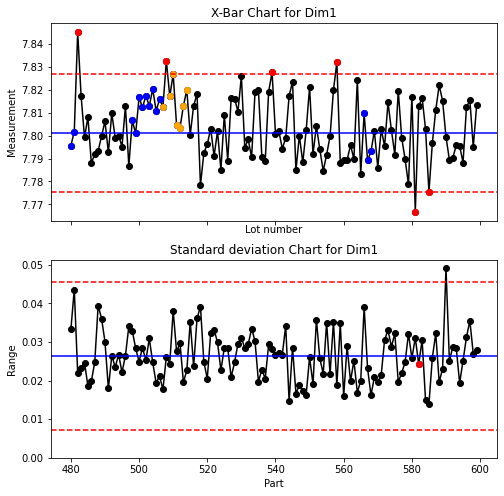

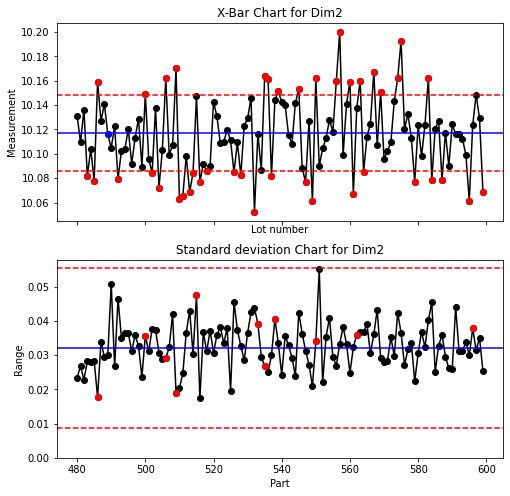

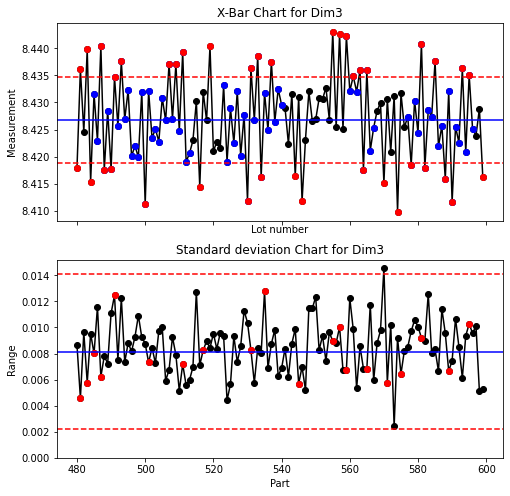

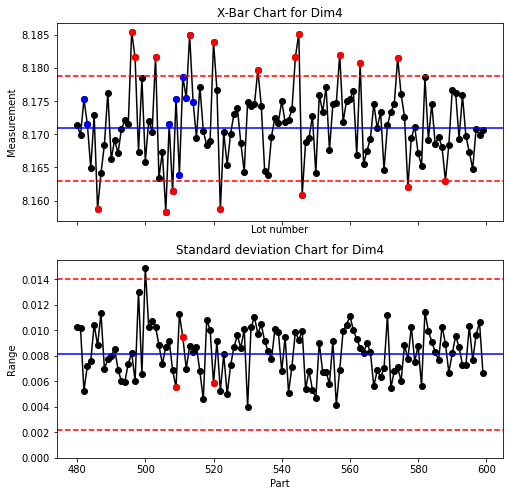

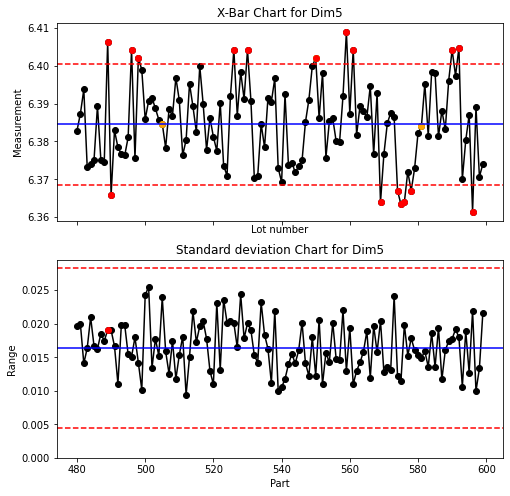

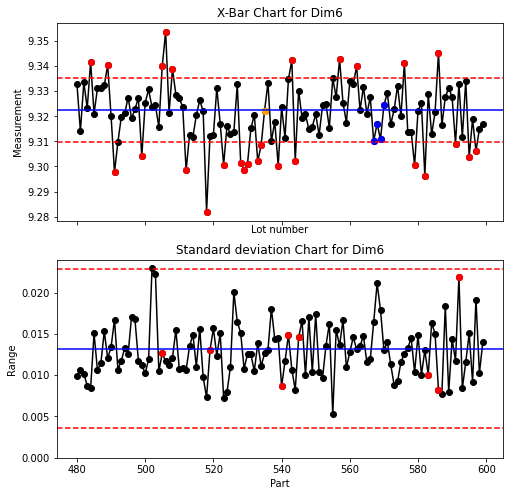

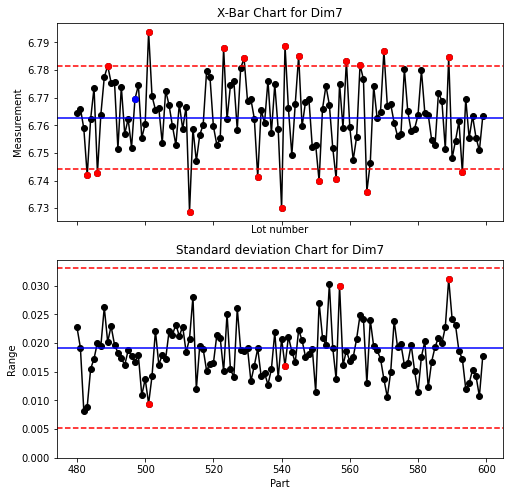

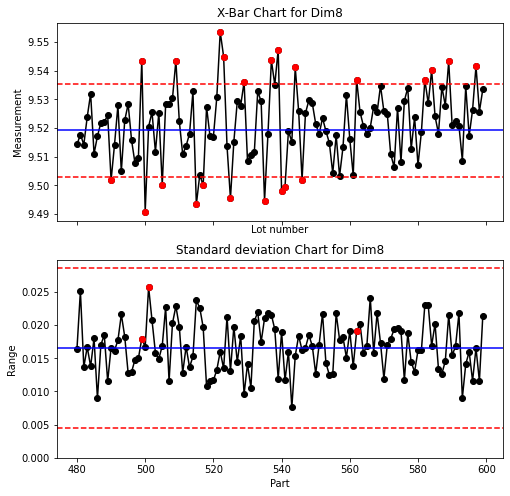

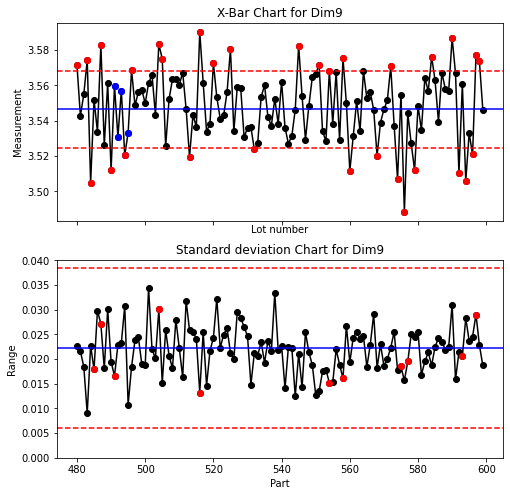

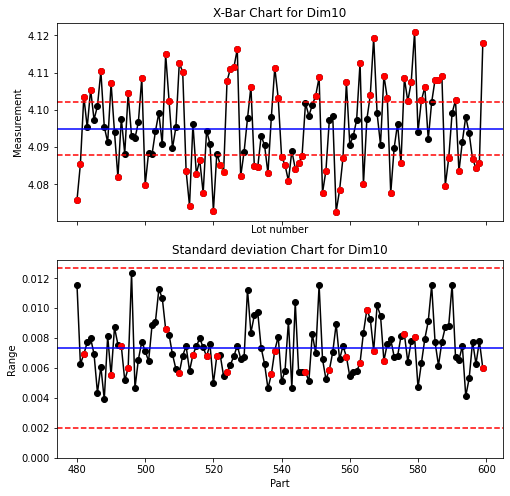

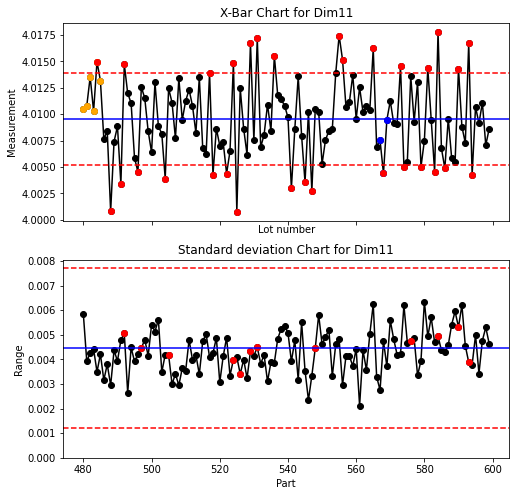

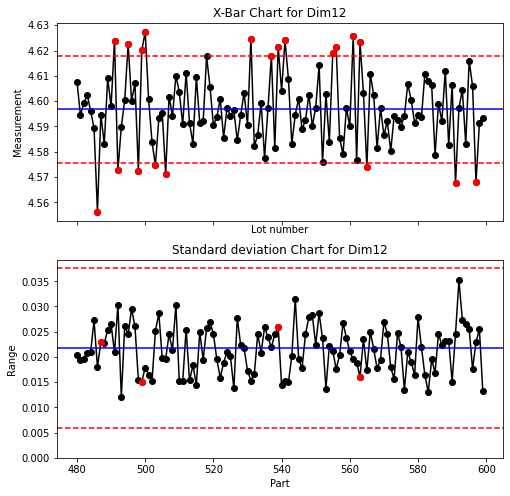

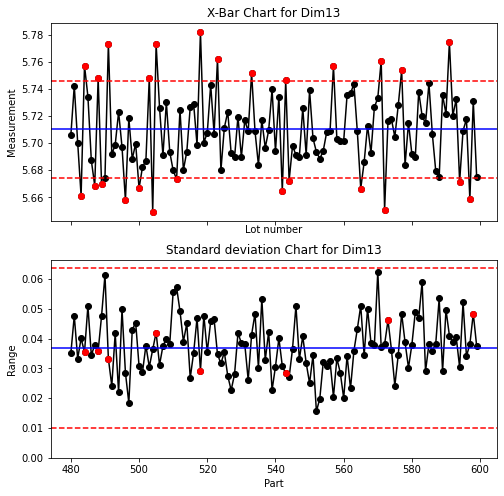

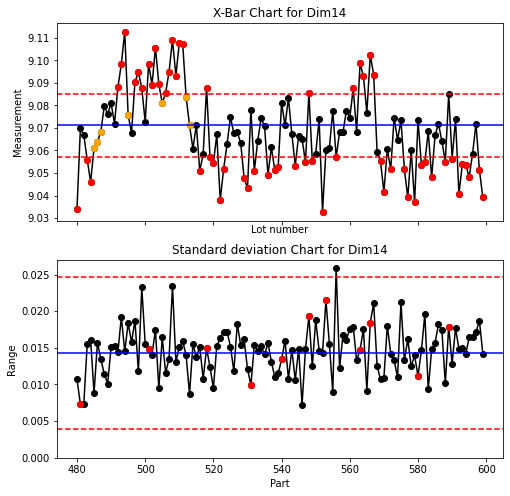

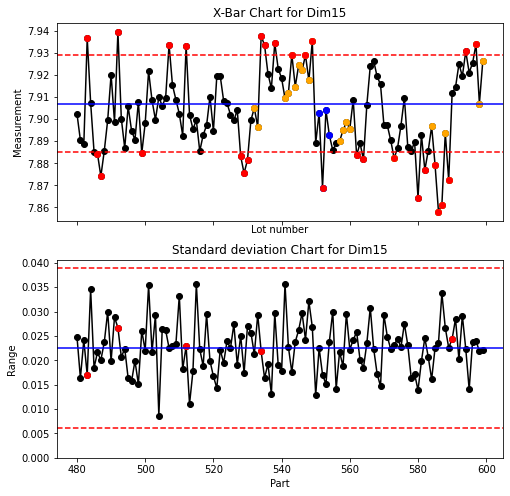

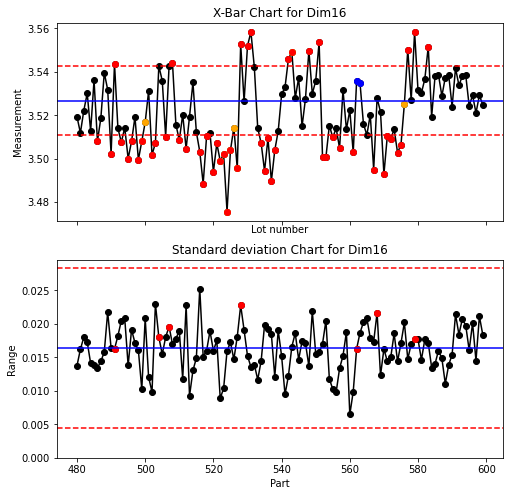

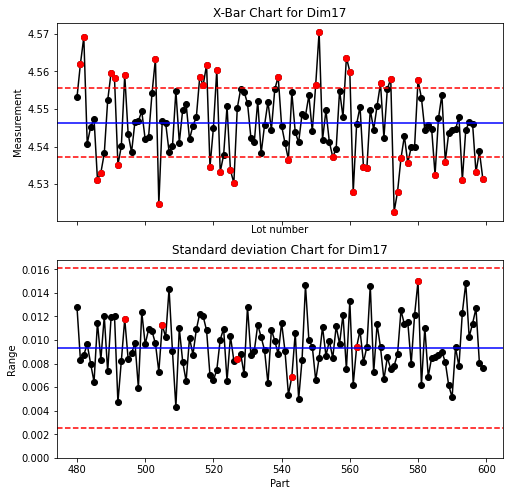

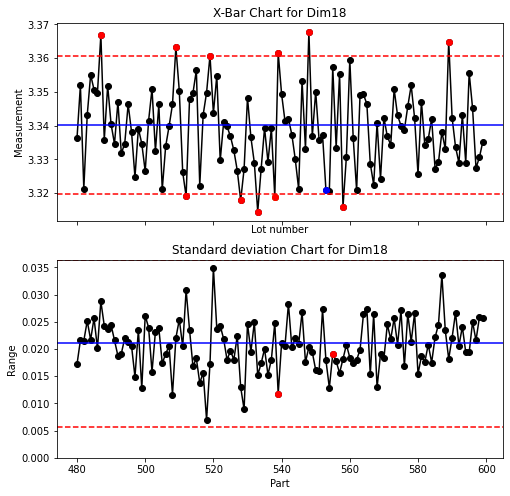

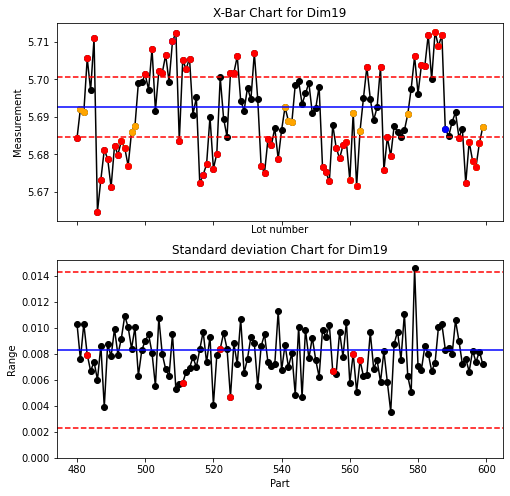

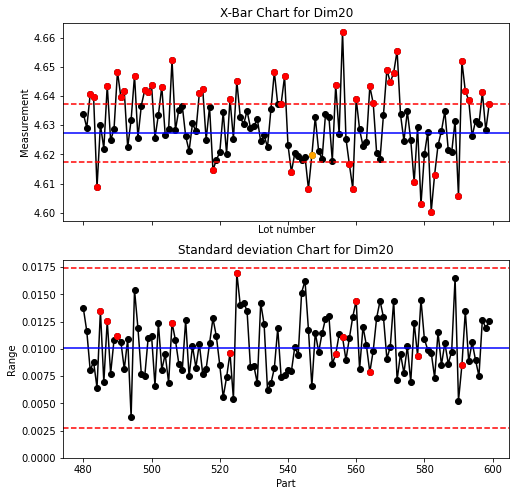

In [38]:
# Show all the dimensions run charts with their Upper and Lower SPC control limits
# Highlight the points that violate one of the SPC rules
for row, index in dim_def.iterrows():
    column = "Dim" + str(row + 1)
    xb = spc.xBarS(all_dims, column, 120)
    lot_parameters["St_dev"+str(row + 1)] = xb['variability']
    lot_parameters["SPC_Rule"+str(row + 1)] = xb['Reason']
    lot_parameters["Mean"+str(row + 1)] = xb['Dim']

##### Create 'lot_params2' DataFrame

lot_params2 DataFrame will have all the data from 'lot_parameters', but instead of having separate column for each dimension parameter, 'dim' column will be added and only 6 columns will be needed:
- btb
- tcv
- t_break
- SPC_Rule
- Scrap
- St_dev

Additionaly, the following columns will be added to lot_params2 from the 'dim_def' table:
- tolerance
- Cp'  
- lots_per_tool
- tool_tol 
- max_tool_wear

In [39]:
lot_parameters

btb1      tcv1  t_break1      btb2      tcv2  t_break2      btb3  \
Lot                                                                         
0    0.010805 -0.000397     False -0.010007 -0.009493     False -0.000326   
1   -0.002843 -0.000397     False  0.013022 -0.009493     False -0.005130   
2   -0.024073 -0.000397     False  0.017433 -0.009493     False -0.007611   
3    0.005842 -0.000397     False  0.031315 -0.009910     False  0.006692   
4    0.009761 -0.000397     False  0.013312 -0.009910     False -0.001799   
..        ...       ...       ...       ...       ...       ...       ...   
595 -0.011687 -0.012776     False -0.035721 -0.007942     False -0.000188   
596  0.014137 -0.012776     False  0.018167 -0.007942     False  0.000794   
597  0.012537 -0.012776     False  0.038539 -0.008601     False -0.001691   
598 -0.007502 -0.012776     False  0.004751 -0.008601     False  0.007548   
599  0.000068 -0.012776     False -0.050177 -0.008601     False -0.002905   

         tcv3  t_break3      btb4  ...    Mean17  St_dev18  SPC_Rule18  \
Lot                                ...                                   
0   -0.007283     False -0.003627  ...  4.533859  0.018350       00000   
1   -0.007283     False  0.004341  ...  4.539848  0.019331       00000   
2   -0.001836     False -0.005075  ...  4.545650  0.014505       00000   
3   -0.001836     False  0.004380  ...  4.539179  0.032154       00000   
4   -0.001262     False -0.003412  ...  4.568063  0.012872       00000   
..        ...       ...       ...  ...       ...       ...         ...   
595 -0.000746     False  0.001487  ...  4.546449  0.019388       00000   
596 -0.008366     False -0.004477  ...  4.546062  0.024993       00000   
597 -0.008366     False -0.006274  ...  4.533132  0.021573       00000   
598 -0.008322     False  0.000585  ...  4.538711  0.025824       00000   
599 -0.008322     False -0.003302  ...  4.531463  0.025621       00000   

       Mean18  St_dev19  SPC_Rule19    Mean19  St_dev20  SPC_Rule20    Mean20  
Lot                                                                            
0    3.322049  0.011925       00001  5.683275  0.012123       00000  4.629245  
1    3.354269  0.009250       00001  5.676821  0.005796       00000  4.620710  
2    3.333108  0.008386       00001  5.679733  0.007940       00011  4.638333  
3    3.348705  0.008494       00001  5.674011  0.008640       00000  4.636021  
4    3.336805  0.006314       00001  5.683845  0.011401       00000  4.635433  
..        ...       ...         ...       ...       ...         ...       ...  
595  3.355663  0.006637       00101  5.683362  0.008960       00000  4.631457  
596  3.345179  0.008248       00101  5.678356  0.007512       00000  4.630342  
597  3.327460  0.007374       00101  5.676741  0.012685       00001  4.641241  
598  3.330580  0.008185       00101  5.683032  0.011903       00000  4.628213  
599  3.335264  0.007194       00100  5.687330  0.012560       00001  4.637179  

[600 rows x 141 columns]

In [40]:
# Define empty 'lot_params2' DataFrame
lot_params2 = pd.DataFrame({'btb':{}, 'tcv':{}, 't_break':{}, 'SPC_Rule':{}, 'Scrap':{}, 'Mean':{}, 'St_dev':{}, 'dim':{}, 'Nominal':{}, 'tolerance':{}, 'Cp':{}, 'lots_per_tool':{}, 'tool_tol ':{}, 'max_tool_wear':{} })

In [41]:
# Iterate through all the dimensions 
for row, index in dim_def.iterrows():
    # dimension idndices start from 1
    dim_index = row + 1
    # create a string version of the dimension index
    n = str(dim_index)
    
    # create a temporary DataFrame to hold a slice of the 'lot_parameters' table relating to the n-th dimension
    dim = pd.DataFrame(lot_parameters[['btb'+n, 'tcv'+n, 't_break'+n, 'SPC_Rule'+n, 'St_dev'+n, 'Scrap'+n, 'Mean'+n]])
    
    # Change the column names in the temporary DataFrame to match lot_params2
    dim = dim.rename(columns = { 'btb'+n:'btb', 'tcv'+n:'tcv', 't_break'+n:'t_break', 'SPC_Rule'+n:'SPC_Rule', 'St_dev'+n:'St_dev', 'Scrap'+n:'Scrap', 'Mean'+n:'Mean' })
    # Add the dimension index
    dim['dim'] = dim_index
    
    # Add the 'tolerance', 'Cp', 'lots_per_tool', 'tool_tol', 'max_tool_wear' from the dim_def table
    # these are not changing between the lots and are defined per dimension
    dim['tolerance'] = dim_def.loc[row, 'tolerance']
    dim['Cp'] = dim_def.loc[row, 'Cp']    
    dim['lots_per_tool'] = dim_def.loc[row, 'lots_per_tool']
    dim['tool_tol '] = dim_def.loc[row, 'tool_tol ']
    dim['max_tool_wear'] = dim_def.loc[row, 'max_tool_wear']
    dim['Nominal'] = dim_def.loc[row, 'Nominal']
    
    # Append the temporary DataFrame to the lot_params2
    lot_params2 = lot_params2.append(dim)

In [42]:
lot_params2

btb       tcv  t_break SPC_Rule  Scrap      Mean    St_dev   dim  \
0    0.010805 -0.000397      0.0    00000    0.0  7.811789  0.027979   1.0   
1   -0.002843 -0.000397      0.0    00000    0.0  7.816831  0.025424   1.0   
2   -0.024073 -0.000397      0.0    00000    0.0  7.778236  0.021229   1.0   
3    0.005842 -0.000397      0.0    00000    0.0  7.808209  0.015427   1.0   
4    0.009761 -0.000397      0.0    00000    0.0  7.823962  0.027447   1.0   
..        ...       ...      ...      ...    ...       ...       ...   ...   
595  0.001225 -0.006473      0.0    00000    0.0  4.631457  0.008960  20.0   
596  0.001287 -0.006473      0.0    00000    0.0  4.630342  0.007512  20.0   
597  0.013162 -0.006473      0.0    00001    0.0  4.641241  0.012685  20.0   
598 -0.004644 -0.006473      0.0    00000    0.0  4.628213  0.011903  20.0   
599  0.004390 -0.006473      0.0    00001    0.0  4.637179  0.012560  20.0   

     Nominal  tolerance        Cp  lots_per_tool  tool_tol   max_tool_wear  
0        7.8        0.1  1.233884            9.0       0.02           0.01  
1        7.8        0.1  1.233884            9.0       0.02           0.01  
2        7.8        0.1  1.233884            9.0       0.02           0.01  
3        7.8        0.1  1.233884            9.0       0.02           0.01  
4        7.8        0.1  1.233884            9.0       0.02           0.01  
..       ...        ...       ...            ...        ...            ...  
595      4.6        0.1  3.274091            9.0       0.02           0.01  
596      4.6        0.1  3.274091            9.0       0.02           0.01  
597      4.6        0.1  3.274091            9.0       0.02           0.01  
598      4.6        0.1  3.274091            9.0       0.02           0.01  
599      4.6        0.1  3.274091            9.0       0.02           0.01  

[12000 rows x 14 columns]

In [43]:
# Calculate the Process performance to the Lower tolerance 
lot_params2['Ppl']= (lot_params2['Mean'] - (lot_params2['Nominal'] - lot_params2['tolerance'] ) )/(3 * lot_params2['St_dev'])

In [44]:
# Calculate the Process performance to the Upper tolerance
lot_params2['Ppu']= ( lot_params2['Nominal'] + lot_params2['tolerance'] - lot_params2['Mean'] )/(3 * lot_params2['St_dev'])

In [45]:
# Calculate Ppk, as a smaller value from Ppl and Ppu
# https://stackoverflow.com/questions/33975128/pandas-get-the-row-wise-minimum-value-of-two-or-more-columns
lot_params2['Ppk'] = lot_params2[['Ppl','Ppu']].min(axis=1)

In [46]:
# Drop the columns 'Nominal', 'Mean', 'Ppl' and  'Ppu'. These were only needed to calculate the Ppk value
lot_params2.drop(columns={'Nominal', 'Mean', 'Ppl', 'Ppu'}, inplace=True)

###### Unpack the SPC_Rule column into 5 separate columns, one for each SPC rule

In [47]:
for i in range(1,6):
    lot_params2['SPC_Rule' + str(i)] = lot_params2['SPC_Rule'].str[-i]

In [48]:
lot_params2.drop(columns=['SPC_Rule'], inplace=True)

In [49]:
#See the final 'lot_params2' table
lot_params2

btb       tcv  t_break  Scrap    St_dev   dim  tolerance        Cp  \
0    0.010805 -0.000397      0.0    0.0  0.027979   1.0        0.1  1.233884   
1   -0.002843 -0.000397      0.0    0.0  0.025424   1.0        0.1  1.233884   
2   -0.024073 -0.000397      0.0    0.0  0.021229   1.0        0.1  1.233884   
3    0.005842 -0.000397      0.0    0.0  0.015427   1.0        0.1  1.233884   
4    0.009761 -0.000397      0.0    0.0  0.027447   1.0        0.1  1.233884   
..        ...       ...      ...    ...       ...   ...        ...       ...   
595  0.001225 -0.006473      0.0    0.0  0.008960  20.0        0.1  3.274091   
596  0.001287 -0.006473      0.0    0.0  0.007512  20.0        0.1  3.274091   
597  0.013162 -0.006473      0.0    0.0  0.012685  20.0        0.1  3.274091   
598 -0.004644 -0.006473      0.0    0.0  0.011903  20.0        0.1  3.274091   
599  0.004390 -0.006473      0.0    0.0  0.012560  20.0        0.1  3.274091   

     lots_per_tool  tool_tol   max_tool_wear       Ppk SPC_Rule1 SPC_Rule2  \
0              9.0       0.02           0.01  1.050929         0         0   
1              9.0       0.02           0.01  1.090430         0         0   
2              9.0       0.02           0.01  1.228464         0         0   
3              9.0       0.02           0.01  1.983368         0         0   
4              9.0       0.02           0.01  0.923456         0         0   
..             ...        ...            ...       ...       ...       ...   
595            9.0       0.02           0.01  2.550016         0         0   
596            9.0       0.02           0.01  3.091075         0         0   
597            9.0       0.02           0.01  1.544106         1         0   
598            9.0       0.02           0.01  2.010389         0         0   
599            9.0       0.02           0.01  1.667206         1         0   

    SPC_Rule3 SPC_Rule4 SPC_Rule5  
0           0         0         0  
1           0         0         0  
2           0         0         0  
3           0         0         0  
4           0         0         0  
..        ...       ...       ...  
595         0         0         0  
596         0         0         0  
597         0         0         0  
598         0         0         0  
599         0         0         0  

[12000 rows x 17 columns]

#### Check the ability of SPC rules to detect the signal.


Below, I will divide the 'lot_params2' table into 2 part:
- on_sample - part of the table that given SPC Rule is triggered
- off_sample - part of the table that given SPC Rule is equal to 0

Next, I will run a t-test for every 'signal' variable to see if there is a difference in the mean between these 2 samples. If the p-Value is smaller than 0.01, plot is display to show the difference in the idtribution with mean highlighted.

In [50]:
# Define a function to plot 2 normal distributions pdf side by side for 2 samples
def show_mean_diff(sample1, sample0, sig, det, tValue):
    fig, ax = plt.subplots(figsize=(8,4))

    #calculate mean values of sample 1 and sample 2
    on_mean = sample1.mean()
    off_mean = sample0.mean()

    #calculate standard variation of sample 1 and 2
    on_std = sample1.std()
    off_std = sample0.std()

    # calculate the extent of the X axis
    # making sure that 99.9% of both distributions will be included
    x_min = min(norm.interval(0.999, loc=on_mean, scale=on_std)[0], norm.interval(0.999, loc=off_mean, scale=off_std)[0])
    x_max = max(norm.interval(0.999, loc=on_mean, scale=on_std)[1], norm.interval(0.999, loc=off_mean, scale=off_std)[1])

    # generate 500 x values using x_min and x_max established above
    x = np.linspace(x_min, x_max, 500)

    # calculate the y values for 1st sample using normal distribution pdf
    y_on = norm.pdf(x, loc=on_mean, scale=on_std)
    # plot the first samples pdf
    ax.plot(x, y_on, '-g',label='{} On'.format(det))
    # add a vertical line for the 1st samples mean
    ax.axvline(on_mean, color='g', linestyle='dashed', linewidth=1)

    # calculate the y values for 2nd sample using normal distribution pdf
    y_off = norm.pdf(x, loc=off_mean, scale=off_std)
    # plot the second samples pdf
    ax.plot(x, y_off, '-r', label='{} Off'.format(det))
    # add a vertical line for the 2nd samples mean
    ax.axvline(off_mean, color='r', linestyle='dashed', linewidth=1)
    
    # Add a rectangle displaying the difference in the means and calculated p-Value
    # With an arrow pointing at the top of the sample 1 pdf
    desc = ax.annotate(r'$\Delta$ in means ='+'{:.3f} \n p-Value={:.3f}'.format(on_mean-off_mean, tValue), # text to be displayed in the on-plot rectangle
                   xy=(on_mean, max(y_on)), xycoords= 'data',                                              # coordinates of the arrow: top of the sample 1 pdf
                   xytext=(0.7, 0.6), textcoords= 'axes fraction',                                         # coordinates of the text (using relative size of the axes)
                   arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),           # style of the arrow
                   horizontalalignment='left', verticalalignment='bottom',                                 # anchor point text
                   fontsize=11,                                                                            
                   bbox=dict(boxstyle="round", fc="w", alpha=0.7)                                          # Stile of the box: rounded edges, white, 30% transparency
                     )
    
    # Add a title of th eplot
    ax.set_title("{} detected by {}".format(sig, det))

    # add a legend
    ax.legend()

    plt.show()

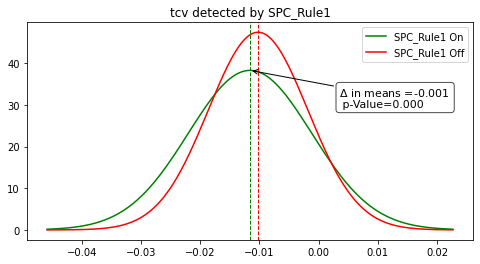

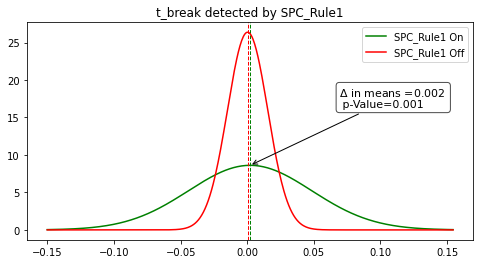

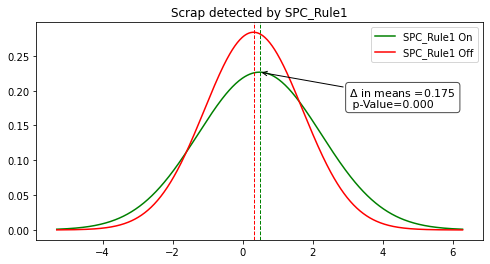

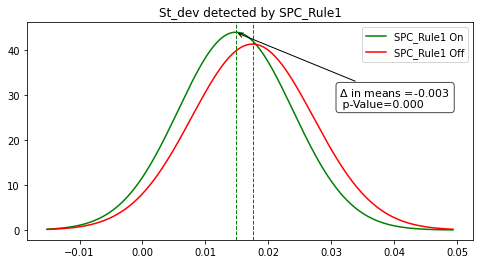

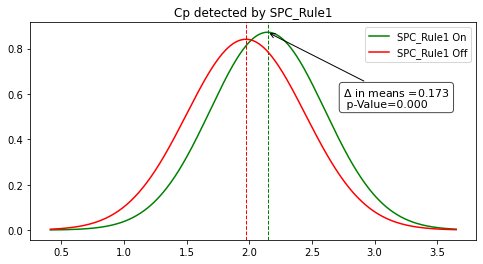

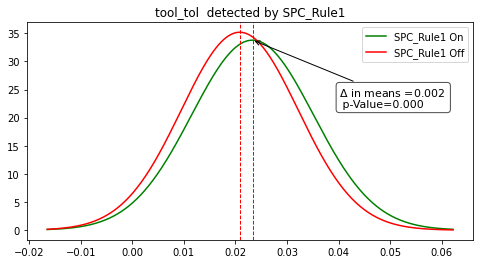

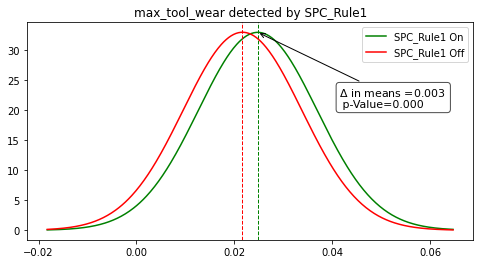

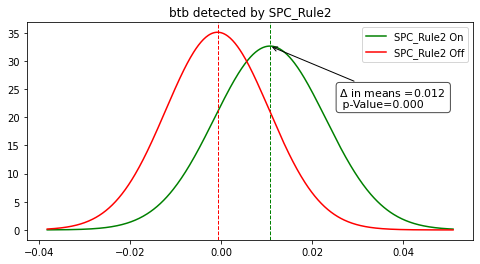

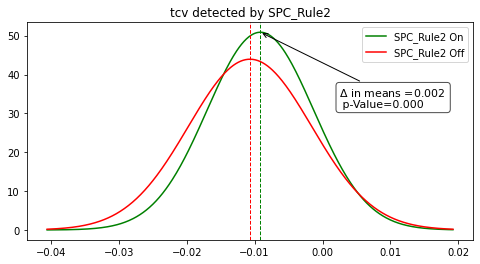

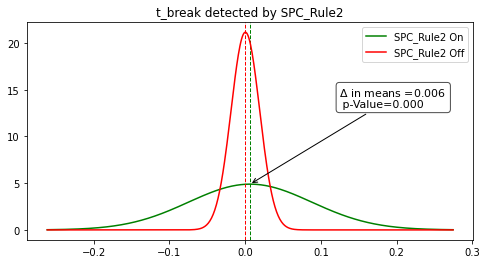

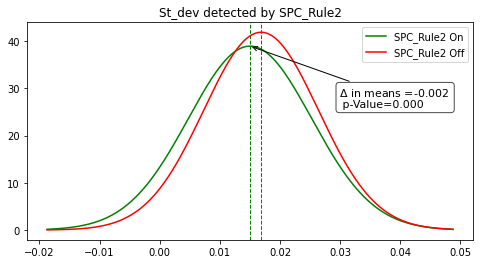

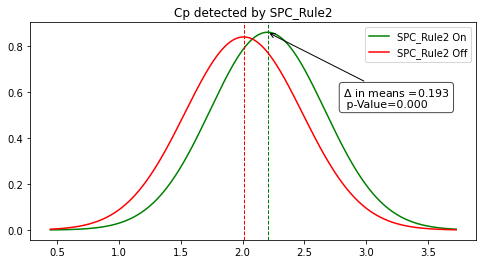

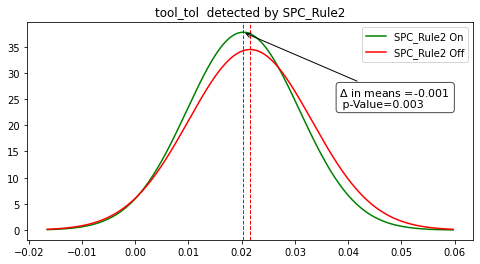

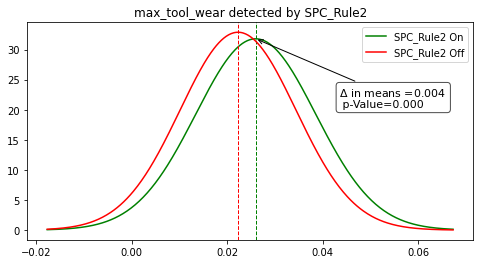

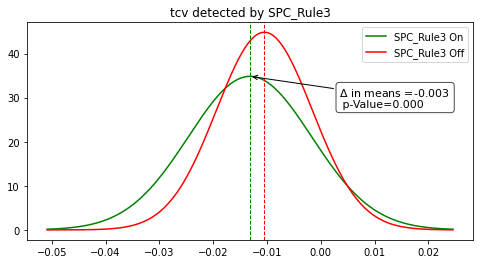

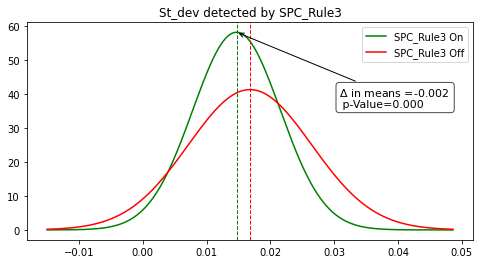

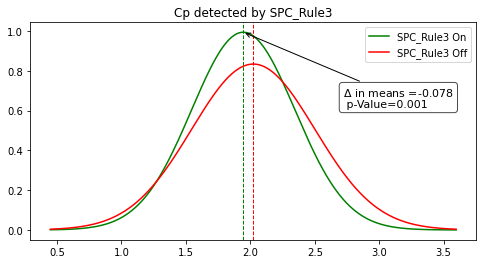

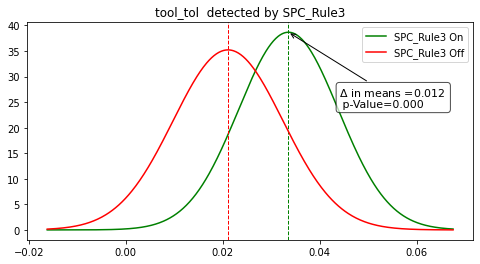

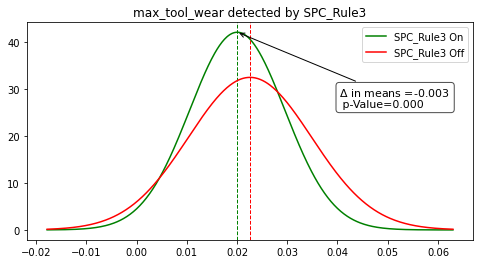

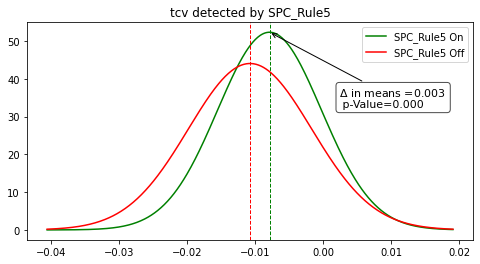

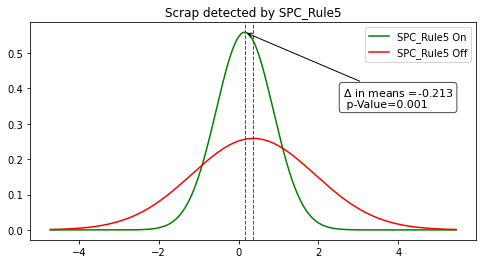

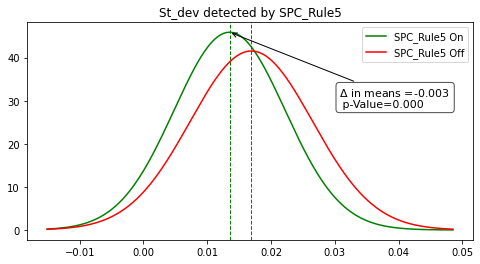

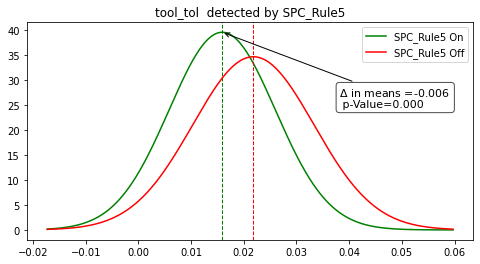

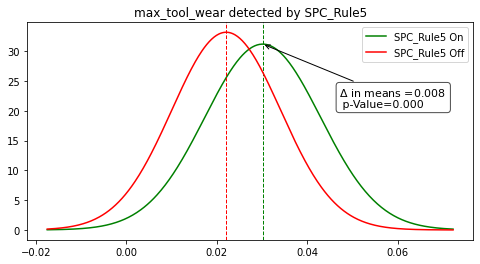

In [51]:
# define the signal columns, columns that are linked to the sources of variation
signal_col = ['btb', 'tcv', 't_break', 'Scrap', 'St_dev', 'Cp', 'tool_tol ', 'max_tool_wear']
# define the detection columns: 5 Statistical Process Controll rules
detection_col = ['SPC_Rule1', 'SPC_Rule2', 'SPC_Rule3', 'SPC_Rule4', 'SPC_Rule5']

#loop through the detection columns
for detect in detection_col: 
    # loop through the signal columns
    for signal in signal_col:       
        
        # take a slice of the DataFrame, where the signal is positive
        sample_on = lot_params2[lot_params2[detect]=='1'][signal]
        # take a slice of the DataFrame, where the signal is negative
        sample_off = lot_params2[lot_params2[detect]=='0'][signal]
        
        # run the t-test 
        ttest = ttest_ind(sample_on, sample_off)
        # if p-value is smaller than 0.01, show the plot displying the difference in the mean
        if ttest[1] < 0.01:
            show_mean_diff(sample_on, sample_off, signal, detect, ttest[1])

## 4. Predict if a lot will have nonconformant parts

#####  Create an input and output dataframes for the logistic regression

In [52]:
lot_params2

btb       tcv  t_break  Scrap    St_dev   dim  tolerance        Cp  \
0    0.010805 -0.000397      0.0    0.0  0.027979   1.0        0.1  1.233884   
1   -0.002843 -0.000397      0.0    0.0  0.025424   1.0        0.1  1.233884   
2   -0.024073 -0.000397      0.0    0.0  0.021229   1.0        0.1  1.233884   
3    0.005842 -0.000397      0.0    0.0  0.015427   1.0        0.1  1.233884   
4    0.009761 -0.000397      0.0    0.0  0.027447   1.0        0.1  1.233884   
..        ...       ...      ...    ...       ...   ...        ...       ...   
595  0.001225 -0.006473      0.0    0.0  0.008960  20.0        0.1  3.274091   
596  0.001287 -0.006473      0.0    0.0  0.007512  20.0        0.1  3.274091   
597  0.013162 -0.006473      0.0    0.0  0.012685  20.0        0.1  3.274091   
598 -0.004644 -0.006473      0.0    0.0  0.011903  20.0        0.1  3.274091   
599  0.004390 -0.006473      0.0    0.0  0.012560  20.0        0.1  3.274091   

     lots_per_tool  tool_tol   max_tool_wear       Ppk SPC_Rule1 SPC_Rule2  \
0              9.0       0.02           0.01  1.050929         0         0   
1              9.0       0.02           0.01  1.090430         0         0   
2              9.0       0.02           0.01  1.228464         0         0   
3              9.0       0.02           0.01  1.983368         0         0   
4              9.0       0.02           0.01  0.923456         0         0   
..             ...        ...            ...       ...       ...       ...   
595            9.0       0.02           0.01  2.550016         0         0   
596            9.0       0.02           0.01  3.091075         0         0   
597            9.0       0.02           0.01  1.544106         1         0   
598            9.0       0.02           0.01  2.010389         0         0   
599            9.0       0.02           0.01  1.667206         1         0   

    SPC_Rule3 SPC_Rule4 SPC_Rule5  
0           0         0         0  
1           0         0         0  
2           0         0         0  
3           0         0         0  
4           0         0         0  
..        ...       ...       ...  
595         0         0         0  
596         0         0         0  
597         0         0         0  
598         0         0         0  
599         0         0         0  

[12000 rows x 17 columns]

In [53]:
# Create a lot_x data frame using all the columns from lot_params2 bar the 'Scrap' column
lot_in = pd.DataFrame(lot_params2.drop(columns=['Scrap', 'dim']))
# Use only 'Scrap' column to create lot_y data frame
lot_out = lot_params2['Scrap']

# Replace all the values were scrap is larger than 0 with 1:
# 0 - no scarpped part in the lot
# 1 - lot has scrapped parts

lot_out.loc[lot_out>0]=1

C:\Users\Przemek\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#####  Use DecisionTreeClassifier to select features that have the largest

In [54]:
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(lot_in, lot_out)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [55]:
# Initialize feature importance DataFrame
fi = pd.DataFrame(columns = ['Feature','Feature Importance'])

for i, column in enumerate(lot_in):
    
    fi.loc[i, 'Feature'] = column
    fi.loc[i, 'Feature Importance'] = dt.feature_importances_[i]

fi.sort_values(by='Feature Importance', ascending=False, inplace=True, ignore_index=True)

In [56]:
# Show the Feature importance table
fi

Feature Feature Importance
0             Ppk           0.943606
1             tcv           0.017614
2             btb           0.017027
3          St_dev           0.013159
4              Cp           0.002784
5       tolerance           0.002163
6       SPC_Rule2           0.001913
7       SPC_Rule5           0.001047
8       tool_tol            0.000687
9         t_break                0.0
10  lots_per_tool                0.0
11  max_tool_wear                0.0
12      SPC_Rule1                0.0
13      SPC_Rule3                0.0
14      SPC_Rule4                0.0

In [57]:
# keep only column that have their 'Feature Importance' greater than 0
fi = fi[fi['Feature Importance']>0]

# Create a use_column series, which holds names of the columns that have feature importance larger than 0
use_column = fi['Feature']
use_column

0          Ppk
1          tcv
2          btb
3       St_dev
4           Cp
5    tolerance
6    SPC_Rule2
7    SPC_Rule5
8    tool_tol 
Name: Feature, dtype: object

#####  Split the data for training and validation sets

In [58]:
X = lot_params2[use_column]
Y = lot_params2['Scrap']

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2)

In [60]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9600, 9)
(9600,)
(2400, 9)
(2400,)


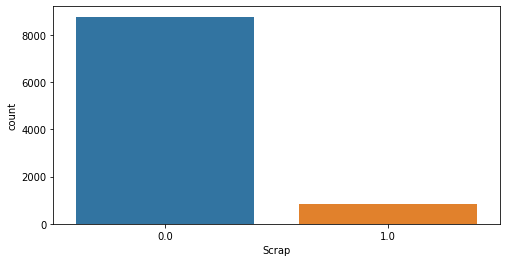

In [61]:
# Let's check if the 0s and 1s in Y_train is evenly distributed 
sns.countplot(x=Y_train)
plt.show()

They are not evenly distributed. The training dataset will need to be balanced.

##### Balance the training dataset

Training dataset is heavily imbalanced towards 0: most of the lots don't have any scrapped parts. This can lead to trained model to be strongly skewed towards the majority class and never to predict the 1.

Balancing completed by undersampling the majority class as per: https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb

In [62]:
undersample = RandomUnderSampler(sampling_strategy = 'majority')

In [63]:
X_train_under, Y_train_under = undersample.fit_resample(X_train, Y_train)

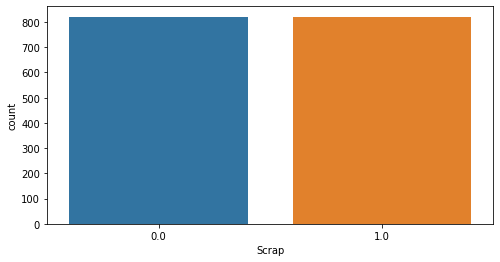

In [64]:
# Let's check if the Y is evenly distributed 
sns.countplot(x=Y_train_under)
plt.show()

#####  Run logistic Regression on balanced training dataset

In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Initialize the logistic regression
log_reg = LogisticRegression(solver = 'lbfgs', C=550.01)

log_reg.fit(X_train_under, Y_train_under)

C:\Users\Przemek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=550.01)

In [66]:
# predict - Predict class labels for samples in X
y_pred = log_reg.predict(X_train)

In [67]:
# Classification Report
print(classification_report(Y_train, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      8779
         1.0       0.72      0.96      0.82       821

    accuracy                           0.96      9600
   macro avg       0.86      0.96      0.90      9600
weighted avg       0.97      0.96      0.97      9600



#####  Hyper parameters tuning

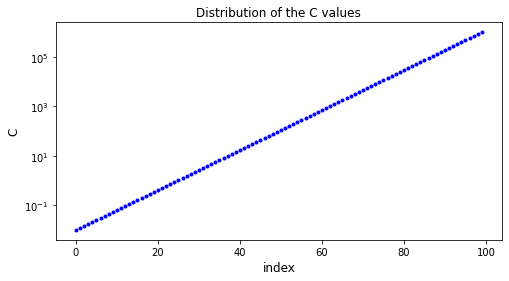

In [68]:
# define a list of c values (inverse of regularization strength) to run the model training with
c_values = np.geomspace(1e-2, 1e6, num=100)

# Show the distribution of the c values on the logarithmic scale
fig, ax = plt.subplots()

ax.plot(c_values, 'b.')
ax.set_yscale('log')

# Set the labels on the Axis
ax.set_xlabel('index', fontsize=12)
ax.set_ylabel('C', fontsize=12)

# Add the title to the Axes
ax.set_title('Distribution of the C values')

plt.show()

In [69]:
%%time
# Measure and display the calculation time

# To switch off convergence warning. For some of the combinations of the Hyper Parameters
# algoritm fails to converge. I'm suppressing this warning type as loop below would result in  tens of these
# warnings being displayed
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

scores_df = pd.DataFrame(columns = ['C', 'max_iter','Score', 'Log loss'])
scores = []
Logarithmic_Loss = []

i = 0

for c in c_values:
    for max_it in np.random.randint(20, 400, 10):
        scores_df.loc[i, 'C'] = c
        scores_df.loc[i, 'max_iter'] = max_it

        # Train the model using c value
        log_reg = LogisticRegression( solver = 'lbfgs', warm_start=True, C=c, max_iter=max_it)
        log_reg.fit(X_train_under, Y_train_under)

        # score the trained model
        score = log_reg.score(X_test, Y_test)
        scores_df.loc[i, 'Score'] = score

        # calculate the logarithmic loss function
        pred_proba_t = log_reg.predict_proba(X_test)
        scores_df.loc[i, 'Log loss'] = log_loss(Y_test, pred_proba_t)

        i+=1

Wall time: 31.8 s


##### Find the parameters that yield the highest score

In [70]:
# Sort the scores df by the 'Score' value, largest on the top
scores_df.sort_values(by='Score', ascending=False, inplace=True)
max_score = scores_df.iloc[0,:]
scores_df.head(10)

C max_iter     Score  Log loss
577     403.701726       39  0.965833   0.07789
910  225701.971963       38     0.965   0.07791
609     705.480231       23     0.965  0.078374
595     585.702082      119     0.965  0.078242
964  572236.765935       38     0.965   0.07791
641    1484.968262      322  0.964583  0.078169
640    1484.968262      191  0.964583  0.078169
613     849.753436       36  0.964583  0.078354
643    1484.968262      167  0.964583  0.078169
614     849.753436      329  0.964583  0.078216

##### Fine the parameters that yield the lowest logarithmic loss

In [71]:
# Sort the scores df by the 'Log loss value' value, largest on the top
scores_df.sort_values(by='Log loss', ascending=True, inplace=True)
min_logloss = scores_df.iloc[0,:]
scores_df.head(10)

C max_iter     Score  Log loss
684     3125.71585       40  0.964583  0.077872
577     403.701726       39  0.965833   0.07789
910  225701.971963       38     0.965   0.07791
964  572236.765935       38     0.965   0.07791
865   89021.508545       55   0.96375  0.077946
858   73907.220335      114  0.963333  0.077958
825   42292.428744       40   0.96375  0.077981
989  830217.568132      114  0.964167  0.077996
885  129154.966501       97  0.964167   0.07801
887  129154.966501       89  0.964167  0.078023

##### Display the Score and log_loss on the scatter plot of Hyper Parameters

In [72]:
# Calculate the parametrs for mapping the log_loss value to the markers size

# Calculate min and max values for the 'log loss' column
ll_min = scores_df['Log loss'].min()
ll_max = scores_df['Log loss'].max()

# define what will be the largest and smallest marker sizes
p_max = 0.01                            # max marker size will be 1/p_max
p_min = 1                                # min marker size will be 1/p_min 

# calculate the parameters for the linear transformation
# the goal is to transform:
# ll_min ---> p_max
# ll_max ---> p_min
a = (p_max-p_min)/(ll_min-ll_max)
b = p_min - a * ll_max

# These parameters will be used in the functions f and g belowS

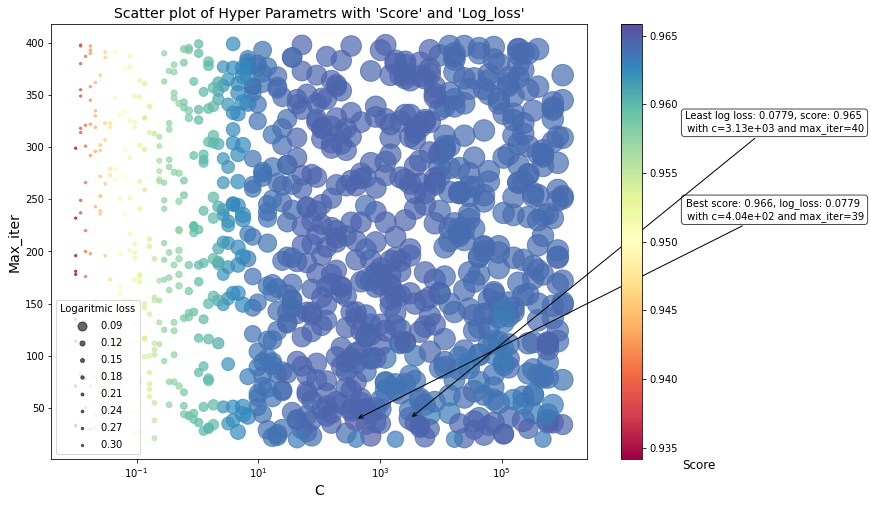

In [73]:
# Plot created with help of this article:
# https://www.tutorialspoint.com/how-can-i-convert-numbers-to-a-color-scale-in-matplotlib
fig, ax = plt.subplots(figsize=(12,8))

cmap = plt.cm.Spectral
norm = colors.Normalize(vmin=scores_df.Score.min(), vmax=scores_df.Score.max())

# Function f will map the log_loss values to the size of the marker
# Function g will reverse this mapping to display correct values on th elegend

scale = 5

# the goal is to have a lot of small and few really large points, large points will represent the smallest values of log_loss
# this mapping will make it easier to see which combinations of hyper parameters yield the best results
f = lambda l: np.reciprocal(l * a + b)*scale

# Function f and g defined to recalculate the size of the marker and scale it back for the label on th elegend
# https://stackoverflow.com/questions/59428303/how-to-scale-legend-elements-down-in-a-scatterplot-matplotlib
g = lambda s: (scale*np.reciprocal(s)- b)*np.reciprocal(a)

# convert dtype object to number as per: 
# https://stackoverflow.com/questions/25952790/convert-pandas-series-from-dtype-object-to-float-and-errors-to-nans
scatter = ax.scatter(scores_df.C,
           scores_df.max_iter, 
           color = cmap(norm(pd.to_numeric(scores_df.Score))),
           s = f(pd.to_numeric(scores_df['Log loss'])),
                     alpha=0.7
          )


# Add the Legend for the colours
# https://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# Add the 'Score' title to the side colour bar
cbar.set_label('Score', fontsize=12, loc='bottom', rotation='horizontal')


#Add legend for the marker size

# produce a legend with a cross section of sizes from the scatter
# from https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
handles, labels = scatter.legend_elements("sizes",                 # options are: 'color' or 'sizes', we'll use 'sizes'
                                          alpha=0.6,               # opacity of this legend
                                          num=8,                   # number of markers to be displayed
                                          func=g                   # recalculate the labels for the markers size back to the log_loss values
                                         )

# Add second legend that represents the size of the markers
legend2 = ax.legend(handles,                                       # list of Artists (patches) to be added to the legend
                    labels,                                        # list of labels to be added to the legend
                    loc="lower left",                              # location of the legend
                    title="Logaritmic loss")                       # The title of th elegend


# Set the labels on the Axis
ax.set_xlabel('C', fontsize=14)
ax.set_ylabel('Max_iter', fontsize=14)

# Set the X scale to log
ax.set_xscale('log')

# Add the title to the Axes
ax.set_title("Scatter plot of Hyper Parametrs with 'Score' and 'Log_loss'", fontsize=14)

# Add annotations

# Get the parameters for the annotation text
c_max, iter_max, score_max, loss_min = max_score

# Annotations added as per:
# https://matplotlib.org/stable/tutorials/text/annotations.html
ax.annotate('Best score: {:.3}, log_loss: {:.3} \n with c={:.3} and max_iter={}'.format(score_max, loss_min, c_max, iter_max),    # Text to be put in the annotation
            xy=(c_max, iter_max),  xycoords='data',                                            # coordinates of the data point 
            xytext=(1.35, 0.6), textcoords= 'axes fraction',                                    # coordinates of the text
            arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),      # parameters of the arrow
            horizontalalignment='center', verticalalignment='top',                             # alignment of the text to the 'xytext' coordinates
            bbox=dict(boxstyle="round", fc="w", alpha=0.7)                                     # parameters of the box around the text
            )

# Get the parameters for the annotation text
c_max, iter_max, score_max, loss_min = min_logloss

# Annotations added as per:
# https://matplotlib.org/stable/tutorials/text/annotations.html
ax.annotate('Least log loss: {:.3}, score: {:.3} \n with c={:.3} and max_iter={}'.format(loss_min, score_max, c_max, iter_max),    # Text to be put in the annotation
            xy=(c_max, iter_max),  xycoords='data',                                            # coordinates of the data point 
            xytext=(1.35, 0.8), textcoords= 'axes fraction',                                    # coordinates of the text
            arrowprops=dict(facecolor='black',  arrowstyle="->", connectionstyle="arc3"),      # parameters of the arrow
            horizontalalignment='center', verticalalignment='top',                             # alignment of the text to the 'xytext' coordinates
            bbox=dict(boxstyle="round", fc="w", alpha=0.7)                                     # parameters of the box around the text
            )


plt.show()

##### Validate the results with confusion matrix

Predict the scrap using trained model and compare it with the actual scrap

In [74]:
# Create and fit 2 models using parameters from Hyper Tuning for the highest score and the least log_loss
best_score_model = LogisticRegression(solver = 'lbfgs', warm_start=True, C=max_score[0], max_iter=max_score[1])
best_score_model.fit(X_train_under, Y_train_under)

least_logloss_model = LogisticRegression(solver = 'lbfgs', warm_start=True, C=min_logloss[0], max_iter=min_logloss[1])
least_logloss_model.fit(X_train_under, Y_train_under)

LogisticRegression(C=3125.7158496882416, max_iter=40, warm_start=True)

In [75]:
# This function is from: https://www.youtube.com/watch?v=NPdn3YPkg9w
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix', normalize=True):
        
    # Normalize the confusion matrix, to have values between 0 and 1
    if normalize:
        cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
        v_min = 0.
        v_max = 1.
        fmt_string = ".2f"
    else:
        cm_norm = cm
        v_min=0.
        v_max=cm.max()
        fmt_string = "d"
    
    fig, ax = plt.subplots(figsize=(8,6))
    
    if classes is not None:
        sns.heatmap(cm_norm, cmap="RdYlGn", xticklabels=classes, yticklabels=classes, vmin=v_min, vmax=v_max, annot=True, fmt=fmt_string, annot_kws={'size':15})
    else:
        sns.heatmap(cm_norm, vmin=0., vmax=1.)
        
    # Set the title
    ax.set_title(title)
    
    # Set the label to the X and Y Axis
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    
    plt.show()

In [76]:
#Predict if the lot would have scrapped parts using the 'best score model':
Y_predict = best_score_model.predict(X_train)

conf_matrix = confusion_matrix(Y_train, Y_predict)

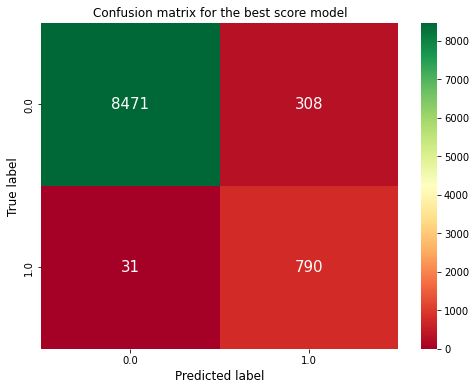

In [77]:
# Plot confusion matrix for the 'Best score model'
plot_confusion_matrix(conf_matrix, classes = log_reg.classes_, title='Confusion matrix for the best score model', normalize=False)

In [78]:
# Print classification report
cr_dict = classification_report(Y_train, Y_predict, output_dict = True)
print(classification_report(Y_train, Y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      8779
         1.0       0.72      0.96      0.82       821

    accuracy                           0.96      9600
   macro avg       0.86      0.96      0.90      9600
weighted avg       0.97      0.96      0.97      9600



In [79]:
#Predict if the lot would have scrapped parts using the 'least logaritmic loss model':
Y_predict = least_logloss_model.predict(X_train)

conf_matrix = confusion_matrix(Y_train, Y_predict)

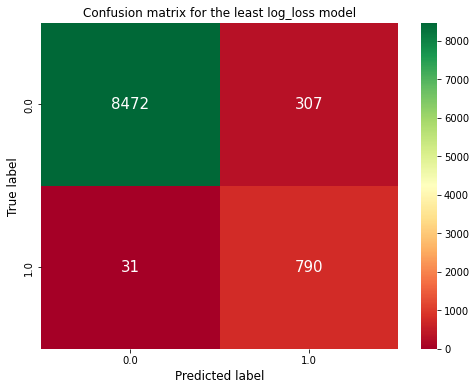

In [80]:
# Plot confusion matrix for the 'Best score model'
plot_confusion_matrix(conf_matrix, classes = log_reg.classes_, title='Confusion matrix for the least log_loss model', normalize=False)

In [81]:
# Print classification report
cr_dict = classification_report(Y_train, Y_predict, output_dict = True)
print(classification_report(Y_train, Y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      8779
         1.0       0.72      0.96      0.82       821

    accuracy                           0.96      9600
   macro avg       0.86      0.96      0.90      9600
weighted avg       0.97      0.96      0.97      9600



## 5. References

[[1] Implementing Six Sigma, Smarter Solutions Using Statistical Methods, Forrect W. Breyfogle III](https://www.amazon.co.uk/Implementing-Six-Sigma-Solutions-Statistical/dp/B07YXBN4YY/ref=sr_1_1?keywords=implementing+six+sigma&qid=1640876748&sr=8-1)</br>
[[2] VARIABILITY IN MANUFACTURING](https://link.springer.com/referenceworkentry/10.1007%2F1-4020-0612-8_1032#Chap1031_1-4020-0612-8_1031)</br>

# End